In [ ]:

!pip install transformers
!pip install bertopic
!pip install nltk
!pip install requests
!pip install pandas
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import time

queries = [
    "machine learning", "climate change", "genomics", "quantum computing",
    "neuroscience", "natural language processing", "artificial intelligence",
    "deep learning", "reinforcement learning", "neural networks",
    "transfer learning", "speech recognition", "language modeling",
    "computer vision", "robotics", "ethical AI"
]


all_data = []

# Function to fetch data from ArXiv API
def fetch_arxiv_data(query, start=0, max_results=100):
    url = f"http://export.arxiv.org/api/query?search_query=all:{query}&start={start}&max_results={max_results}"
    response = requests.get(url)
    if response.status_code == 200:
        root = ET.fromstring(response.text)
        papers = []
        for entry in root.findall("{http://www.w3.org/2005/Atom}entry"):
            papers.append({
                'title': entry.find("{http://www.w3.org/2005/Atom}title").text,
                'abstract': entry.find("{http://www.w3.org/2005/Atom}summary").text,
                'published': entry.find("{http://www.w3.org/2005/Atom}published").text,
                'source': 'arXiv'
            })
        return papers
    return []




In [ ]:
# Function to fetch data from PubMed API
def fetch_pubmed_data(query, retmax=10):
    search_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmax={retmax}&retmode=json"
    search_response = requests.get(search_url).json()
    pmids = search_response.get('esearchresult', {}).get('idlist', [])
    papers = []
    if pmids:
        ids = ",".join(pmids)
        fetch_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={ids}&retmode=xml"
        fetch_response = requests.get(fetch_url)
        root = ET.fromstring(fetch_response.text)
        for article in root.findall(".//PubmedArticle"):
            title = article.find(".//ArticleTitle").text
            abstract = article.find(".//AbstractText")
            abstract = abstract.text if abstract is not None else "No abstract"
            date = article.find(".//PubDate/Year").text if article.find(".//PubDate/Year") else "No date"
            papers.append({
                'title': title,
                'abstract': abstract,
                'published': date,
                'source': 'PubMed'
            })
    return papers

In [ ]:
# Function to fetch data from CrossRef API
def fetch_crossref_data(query, rows=10):
    url = f"https://api.crossref.org/works?query={query}&rows={rows}"
    response = requests.get(url)
    papers = []
    if response.status_code == 200:
        results = response.json().get("message", {}).get("items", [])
        for item in results:
            title = item.get("title", ["No title"])[0]
            abstract = item.get("abstract", "No abstract")
            date_parts = item.get("published-print", {}).get("date-parts", [[None]])
            year = date_parts[0][0] if date_parts[0][0] is not None else "No date"
            papers.append({
                'title': title,
                'abstract': abstract,
                'published': year,
                'source': 'CrossRef'
            })
    return papers


In [ ]:
# Fetch data for each query from ArXiv, PubMed, and CrossRef
for query in queries:
    print(f"Fetching data for query: {query}")


    for start in range(0, 500, 100):  # Fetch up to 500 results in batches of 100
        all_data.extend(fetch_arxiv_data(query, start=start, max_results=100))
        time.sleep(1)  # Delay to avoid rate limits

    all_data.extend(fetch_pubmed_data(query))
    all_data.extend(fetch_crossref_data(query))


df = pd.DataFrame(all_data)
df['published_date'] = pd.to_datetime(df['published'], errors='coerce').dt.to_period("Y")
print(f"Total entries collected: {len(df)}")
df.head()


Fetching data for query: machine learning
Fetching data for query: climate change
Fetching data for query: genomics
Fetching data for query: quantum computing
Fetching data for query: neuroscience
Fetching data for query: natural language processing
Fetching data for query: artificial intelligence
Fetching data for query: deep learning
Fetching data for query: reinforcement learning
Fetching data for query: neural networks
Fetching data for query: transfer learning
Fetching data for query: speech recognition
Fetching data for query: language modeling
Fetching data for query: computer vision
Fetching data for query: robotics
Fetching data for query: ethical AI
Total entries collected: 8121


<ipython-input-5-0f4fa14d8dee>:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['published_date'] = pd.to_datetime(df['published'], errors='coerce').dt.to_period("Y")


title  \
0   Lecture Notes: Optimization for Machine Learning   
1  An Optimal Control View of Adversarial Machine...   
2  Minimax deviation strategies for machine learn...   
3  Machine Learning for Clinical Predictive Analy...   
4  Towards Modular Machine Learning Solution Deve...   

                                            abstract             published  \
0    Lecture notes on optimization for machine le...  2019-09-08T21:49:42Z   
1    I describe an optimal control view of advers...  2018-11-11T14:28:34Z   
2    The article is devoted to the problem of sma...  2017-07-16T09:15:08Z   
3    In this chapter, we provide a brief overview...  2019-09-19T22:02:00Z   
4    Machine learning technologies have demonstra...  2023-01-23T22:54:34Z   

  source published_date  
0  arXiv           2019  
1  arXiv           2018  
2  arXiv           2017  
3  arXiv           2019  
4  arXiv           2023

In [ ]:
import nltk
nltk.data.path.clear()


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

nlp = spacy.load("en_core_web_sm")


def preprocess_text(text):
    if text is None:
        return []
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return tokens

df['processed_abstract'] = df['abstract'].apply(preprocess_text)

df.head()


title  \
0   Lecture Notes: Optimization for Machine Learning   
1  An Optimal Control View of Adversarial Machine...   
2  Minimax deviation strategies for machine learn...   
3  Machine Learning for Clinical Predictive Analy...   
4  Towards Modular Machine Learning Solution Deve...   

                                            abstract             published  \
0    Lecture notes on optimization for machine le...  2019-09-08T21:49:42Z   
1    I describe an optimal control view of advers...  2018-11-11T14:28:34Z   
2    The article is devoted to the problem of sma...  2017-07-16T09:15:08Z   
3    In this chapter, we provide a brief overview...  2019-09-19T22:02:00Z   
4    Machine learning technologies have demonstra...  2023-01-23T22:54:34Z   

  source published_date                                 processed_abstract  
0  arXiv           2019  [lecture, note, optimization, machine, learnin...  
1  arXiv           2018  [describe, optimal, control, view, adversarial...  
2  arXiv           2017  [article, devoted, problem, small, learning, s...  
3  arXiv           2019  [chapter, provide, brief, overview, apply, mac...  
4  arXiv           2023  [machine, learning, technology, demonstrate, i...

In [ ]:
# Specify the directory for NLTK data
import nltk
nltk.data.path.append('/usr/local/share/nltk_data/')

# Download necessary NLTK resources again
nltk.download('punkt', download_dir='/usr/local/share/nltk_data/')
nltk.download('stopwords', download_dir='/usr/local/share/nltk_data/')


[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/share/nltk_data/...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data/...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd

df['published_date'] = pd.to_datetime(df['published'], errors='coerce').dt.to_period("Y")

# Save the DataFrame to an Excel file
output_file = "research_data.xlsx"
df.to_excel(output_file, index=False)

print(f"Data successfully saved to {output_file}")


Data successfully saved to research_data.xlsx


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# TF-IDF Analysis
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_abstract'].apply(lambda x: ' '.join(x)))
terms = tfidf_vectorizer.get_feature_names_out()


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out


term_freq_time_series = df['processed_abstract'].apply(lambda x: ' '.join(x)).value_counts().sort_index()
data = []
labels = []
sequence_length = 10
for i in range(len(term_freq_time_series) - sequence_length):
    data.append(term_freq_time_series.values[i:i + sequence_length])
    labels.append(term_freq_time_series.values[i + sequence_length])

dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32))
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

input_size = 1
hidden_size = 50
output_size = 1
lstm_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

for epoch in range(50):
    for seq, target in data_loader:
        optimizer.zero_grad()
        output = lstm_model(seq.unsqueeze(-1))
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()


In [ ]:
terms_of_interest = ["machine learning", "artificial intelligence", "neural networks", "deep learning", "reinforcement learning"]


In [ ]:
# Ensure 'published_date' is in datetime format and extract the year
df['published_date'] = pd.to_datetime(df['published'], errors='coerce')
df['year'] = df['published_date'].dt.year


In [ ]:
print(df[['published_date', 'year']].head())


             published_date    year
0 2019-09-08 21:49:42+00:00  2019.0
1 2018-11-11 14:28:34+00:00  2018.0
2 2017-07-16 09:15:08+00:00  2017.0
3 2019-09-19 22:02:00+00:00  2019.0
4 2023-01-23 22:54:34+00:00  2023.0


In [ ]:
df['year'] = df['year'].astype('Int64')


In [ ]:
print(df[['published_date', 'year']].dtypes)


published_date    datetime64[ns, UTC]
year                            Int64
dtype: object


In [ ]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

terms_of_interest = ["machine learning", "climate change", "genomics", "quantum computing",
    "neuroscience", "natural language processing", "artificial intelligence",
    "deep learning", "reinforcement learning", "neural networks",
    "transfer learning", "speech recognition", "language modeling",
    "computer vision", "robotics", "ethical AI"]

term_embeddings_over_time = {}

# Process each term over all available years
for term in terms_of_interest:
    term_embeddings_over_time[term] = {}
    for year in sorted(df['year'].dropna().unique()):  # Ensure 'year' column exists and is valid
        # Filter abstracts published in the current year
        texts = df[df['year'] == year]['processed_abstract'].apply(lambda x: ' '.join(x)).tolist()

        # Initialize a list to store embeddings for each paper containing the term in the specified year
        yearly_embeddings = []

        for text in texts:
            # Only include papers containing the term
            if term in text:
                inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
                outputs = model(**inputs)
                embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
                yearly_embeddings.append(embedding)

        # Calculate the average embedding for the term in this year if any papers matched
        if yearly_embeddings:
            term_embeddings_over_time[term][year] = np.mean(yearly_embeddings, axis=0)
        else:
            term_embeddings_over_time[term][year] = None  # No data for this term in this year

volatility_scores = {}
for term, yearly_embeddings in term_embeddings_over_time.items():
    years = sorted(yearly_embeddings.keys())
    scores = []
    for i in range(1, len(years)):
        if yearly_embeddings[years[i - 1]] is not None and yearly_embeddings[years[i]] is not None:
            # Compute cosine similarity between consecutive years
            sim = cosine_similarity(yearly_embeddings[years[i - 1]], yearly_embeddings[years[i]])
            scores.append(1 - sim[0][0])  # Volatility is 1 - similarity
    volatility_scores[term] = np.mean(scores) if scores else 0

print("Context Volatility Scores:\n", volatility_scores)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Context Volatility Scores:
 {'machine learning': 0.029308348894119263, 'climate change': 0.04144692137127831, 'genomics': 0.07904073596000671, 'quantum computing': 0.07120444093431745, 'neuroscience': 0.04676815710569683, 'natural language processing': 0.03267342553419225, 'artificial intelligence': 0.04764516730057566, 'deep learning': 0.013856127858161926, 'reinforcement learning': 0.049702930450439456, 'neural networks': 0, 'transfer learning': 0.022335345546404522, 'speech recognition': 0.025272837706974575, 'language modeling': 0.02389689286549886, 'computer vision': 0.044809091836214066, 'robotics': 0, 'ethical AI': 0}


In [ ]:
terms_of_interest = ["machine learning", "climate change","quantum computing",
    "neuroscience", "natural language processing", "artificial intelligence",
    "deep learning", "reinforcement learning",
    "transfer learning", "speech recognition", "language modeling",
    "computer vision"]

# Calculate term frequencies
term_frequencies = {term: {} for term in terms_of_interest}

for term in terms_of_interest:
    for year in sorted(df['year'].dropna().unique()):
        # Count occurrences of the exact term in abstracts for the given year
        term_frequencies[term][year] = df[df['year'] == year]['processed_abstract'].apply(
            lambda x: f" {term} " in f" {' '.join(x)} ".lower()  # Ensure exact matching
        ).sum()

term_frequencies_df = pd.DataFrame(term_frequencies).fillna(0).astype(int)
term_frequencies_df.index.name = 'Year'

print(term_frequencies_df)


      machine learning  climate change  quantum computing  neuroscience  \
Year                                                                      
1994                 0               0                  1             0   
1995                 1               0                  0             0   
1996                 1               0                  2             0   
1997                 0               0                  1             0   
1998                 0               0                  1             0   
1999                 0               0                  3             1   
2000                 0               0                  5             1   
2001                 0               0                  1             0   
2002                 0               0                  1             0   
2003                 0               1                  1             0   
2004                 0               3                  2             4   
2005                 0   

In [ ]:
print(term_frequencies_df.head())


      machine learning  climate change  quantum computing  neuroscience  \
Year                                                                      
1994                 0               0                  1             0   
1995                 1               0                  0             0   
1996                 1               0                  2             0   
1997                 0               0                  1             0   
1998                 0               0                  1             0   

      natural language processing  artificial intelligence  deep learning  \
Year                                                                        
1994                            2                        0              0   
1995                            3                        1              0   
1996                            3                        0              0   
1997                            4                        0              0   
1998        

In [ ]:
print(term_frequencies_df['machine learning'].rank(method="min", ascending=False))


Year
1994    18.0
1995    15.0
1996    15.0
1997    18.0
1998    18.0
1999    18.0
2000    18.0
2001    18.0
2002    18.0
2003    18.0
2004    18.0
2005    18.0
2006    18.0
2007    18.0
2008    18.0
2009    13.0
2010    18.0
2011    15.0
2012    14.0
2013    12.0
2014    11.0
2015    10.0
2016     9.0
2017     8.0
2018     7.0
2019     2.0
2020     1.0
2021     3.0
2022     6.0
2023     5.0
2024     4.0
Name: machine learning, dtype: float64


In [ ]:
ranks = term_frequencies_df["machine learning"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'machine learning': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'machine learning': 1.3333333333333333

Year
1994    18.0
1995    15.0
1996    15.0
1997    18.0
1998    18.0
1999    18.0
2000    18.0
2001    18.0
2002    18.0
2003    18.0
2004    18.0
2005    18.0
2006    18.0
2007    18.0
2008    18.0
2009    13.0
2010    18.0
2011    15.0
2012    14.0
2013    12.0
2014    11.0
2015    10.0
2016     9.0
2017     8.0
2018     7.0
2019     2.0
2020     1.0
2021     3.0
2022     6.0
2023     5.0
2024     4.0
Name: machine learning, dtype: float64


In [ ]:
ranks = term_frequencies_df["climate change"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'climate change': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'climate change': 2.2

Year
1994    23.0
1995    23.0
1996    23.0
1997    23.0
1998    23.0
1999    23.0
2000    23.0
2001    23.0
2002    23.0
2003    21.0
2004    17.0
2005    19.0
2006    17.0
2007    21.0
2008    14.0
2009    12.0
2010    16.0
2011    14.0
2012    12.0
2013    19.0
2014    10.0
2015     7.0
2016     8.0
2017    11.0
2018     9.0
2019     6.0
2020     5.0
2021     3.0
2022     4.0
2023     2.0
2024     1.0
Name: climate change, dtype: float64


In [ ]:
ranks = term_frequencies_df["quantum computing"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'quantum computing': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'quantum computing': 4.866666666666666

Year
1994    25.0
1995    31.0
1996    18.0
1997    25.0
1998    25.0
1999    13.0
2000     9.0
2001    25.0
2002    25.0
2003    25.0
2004    18.0
2005    13.0
2006    18.0
2007    13.0
2008    10.0
2009    18.0
2010    13.0
2011    18.0
2012    18.0
2013    10.0
2014    10.0
2015    18.0
2016     8.0
2017    13.0
2018     7.0
2019     6.0
2020     5.0
2021     3.0
2022     4.0
2023     2.0
2024     1.0
Name: quantum computing, dtype: float64


In [ ]:
ranks = term_frequencies_df["neuroscience"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'neuroscience': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'neuroscience': 2.4

Year
1994    23.0
1995    23.0
1996    23.0
1997    23.0
1998    23.0
1999    19.0
2000    19.0
2001    23.0
2002    23.0
2003    23.0
2004    15.0
2005    23.0
2006    19.0
2007    15.0
2008    19.0
2009    17.0
2010    13.0
2011    14.0
2012    17.0
2013    12.0
2014    11.0
2015    10.0
2016     7.0
2017     9.0
2018     8.0
2019     5.0
2020     2.0
2021     3.0
2022     5.0
2023     4.0
2024     1.0
Name: neuroscience, dtype: float64


In [ ]:
ranks = term_frequencies_df["natural language processing"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

rank_based_volatility = rank_diff.mean()

# Display results
print(f"Rank-Based Volatility for 'natural language processing': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'natural language processing': 1.9333333333333333

Year
1994    17.0
1995    15.0
1996    15.0
1997    13.0
1998    22.0
1999    22.0
2000    22.0
2001    22.0
2002    22.0
2003    19.0
2004    22.0
2005    22.0
2006    22.0
2007    17.0
2008    19.0
2009    22.0
2010    22.0
2011    19.0
2012    11.0
2013    13.0
2014    10.0
2015     9.0
2016    11.0
2017     8.0
2018     7.0
2019     6.0
2020     5.0
2021     4.0
2022     3.0
2023     2.0
2024     1.0
Name: natural language processing, dtype: float64


In [ ]:
ranks = term_frequencies_df["artificial intelligence"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'artificial intelligence': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'artificial intelligence': 2.3333333333333335

Year
1994    23.0
1995    19.0
1996    23.0
1997    23.0
1998    23.0
1999    23.0
2000    23.0
2001    23.0
2002    23.0
2003    19.0
2004    17.0
2005    19.0
2006    19.0
2007    14.0
2008    17.0
2009    14.0
2010    23.0
2011    16.0
2012    12.0
2013     8.0
2014    10.0
2015    13.0
2016    10.0
2017     9.0
2018     7.0
2019     6.0
2020     5.0
2021     3.0
2022     4.0
2023     2.0
2024     1.0
Name: artificial intelligence, dtype: float64


In [ ]:
ranks = term_frequencies_df["deep learning"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'deep learning': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'deep learning': 0.9

Year
1994    14.0
1995    14.0
1996    14.0
1997    14.0
1998    14.0
1999    14.0
2000    14.0
2001    14.0
2002    14.0
2003    14.0
2004    14.0
2005    14.0
2006    14.0
2007    14.0
2008    14.0
2009    14.0
2010    14.0
2011    14.0
2012    13.0
2013    11.0
2014    11.0
2015    10.0
2016     9.0
2017     8.0
2018     6.0
2019     3.0
2020     1.0
2021     4.0
2022     7.0
2023     2.0
2024     5.0
Name: deep learning, dtype: float64


In [ ]:
ranks = term_frequencies_df["reinforcement learning"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'reinforcement learning': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'reinforcement learning': 3.533333333333333

Year
1994    21.0
1995    21.0
1996    16.0
1997    21.0
1998    21.0
1999    21.0
2000    21.0
2001    21.0
2002    21.0
2003    13.0
2004    16.0
2005    13.0
2006    21.0
2007    16.0
2008    21.0
2009    16.0
2010    13.0
2011    10.0
2012    21.0
2013    10.0
2014    16.0
2015    12.0
2016     9.0
2017     8.0
2018     6.0
2019     7.0
2020     1.0
2021     4.0
2022     3.0
2023     2.0
2024     5.0
Name: reinforcement learning, dtype: float64


In [ ]:
ranks = term_frequencies_df["transfer learning"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'transfer learning': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'transfer learning': 0.8

Year
1994    14.0
1995    14.0
1996    14.0
1997    14.0
1998    14.0
1999    14.0
2000    14.0
2001    14.0
2002    14.0
2003    14.0
2004    14.0
2005    14.0
2006    14.0
2007    14.0
2008    14.0
2009    14.0
2010    14.0
2011    14.0
2012    11.0
2013    10.0
2014    11.0
2015    13.0
2016     9.0
2017     8.0
2018     7.0
2019     5.0
2020     1.0
2021     2.0
2022     3.0
2023     5.0
2024     4.0
Name: transfer learning, dtype: float64


In [ ]:
ranks = term_frequencies_df["speech recognition"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'speech recognition': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'speech recognition': 4.166666666666667

Year
1994    13.0
1995    23.0
1996    12.0
1997    16.0
1998    23.0
1999    23.0
2000    19.0
2001    23.0
2002    16.0
2003    19.0
2004    23.0
2005    19.0
2006    23.0
2007    13.0
2008    23.0
2009    19.0
2010    16.0
2011    23.0
2012    23.0
2013    11.0
2014    13.0
2015    10.0
2016     9.0
2017     8.0
2018     7.0
2019     6.0
2020     5.0
2021     4.0
2022     1.0
2023     3.0
2024     2.0
Name: speech recognition, dtype: float64


In [ ]:
ranks = term_frequencies_df["language modeling"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'language modeling': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'language modeling': 1.3

Year
1994    14.0
1995    12.0
1996    14.0
1997    14.0
1998    14.0
1999    14.0
2000    12.0
2001    14.0
2002    14.0
2003    14.0
2004    14.0
2005    14.0
2006    14.0
2007    14.0
2008    14.0
2009    14.0
2010    14.0
2011    14.0
2012    14.0
2013    10.0
2014    14.0
2015    10.0
2016     9.0
2017     4.0
2018     4.0
2019     4.0
2020     4.0
2021     3.0
2022     8.0
2023     2.0
2024     1.0
Name: language modeling, dtype: float64


In [ ]:
ranks = term_frequencies_df["computer vision"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'computer vision': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'computer vision': 1.2333333333333334

Year
1994    19.0
1995    19.0
1996    19.0
1997    19.0
1998    19.0
1999    19.0
2000    19.0
2001    19.0
2002    19.0
2003    19.0
2004    19.0
2005    19.0
2006    13.0
2007    19.0
2008    16.0
2009    16.0
2010    16.0
2011    13.0
2012    15.0
2013    12.0
2014    11.0
2015     9.0
2016     9.0
2017     8.0
2018     7.0
2019     6.0
2020     5.0
2021     3.0
2022     4.0
2023     1.0
2024     2.0
Name: computer vision, dtype: float64


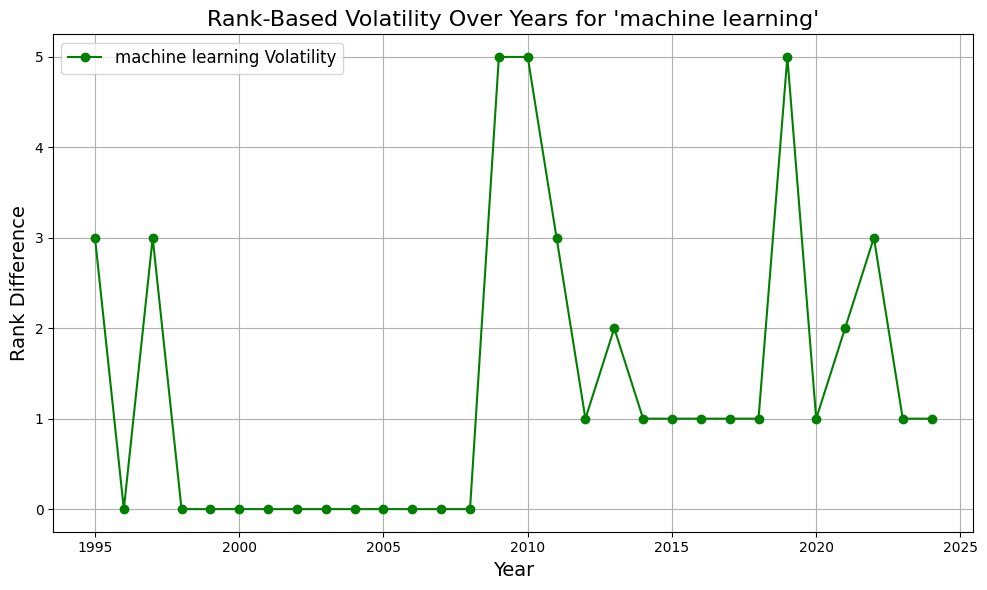

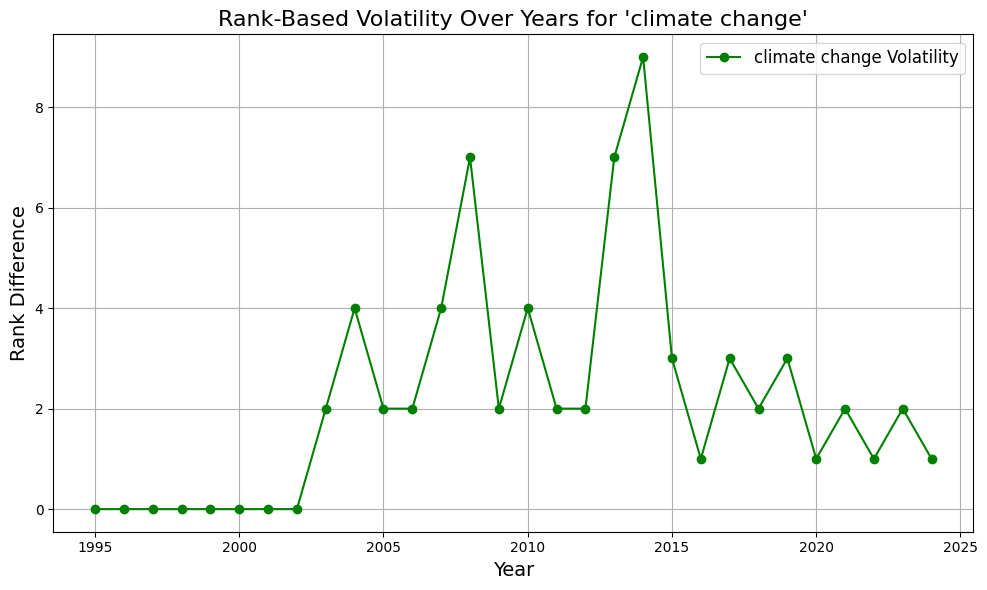

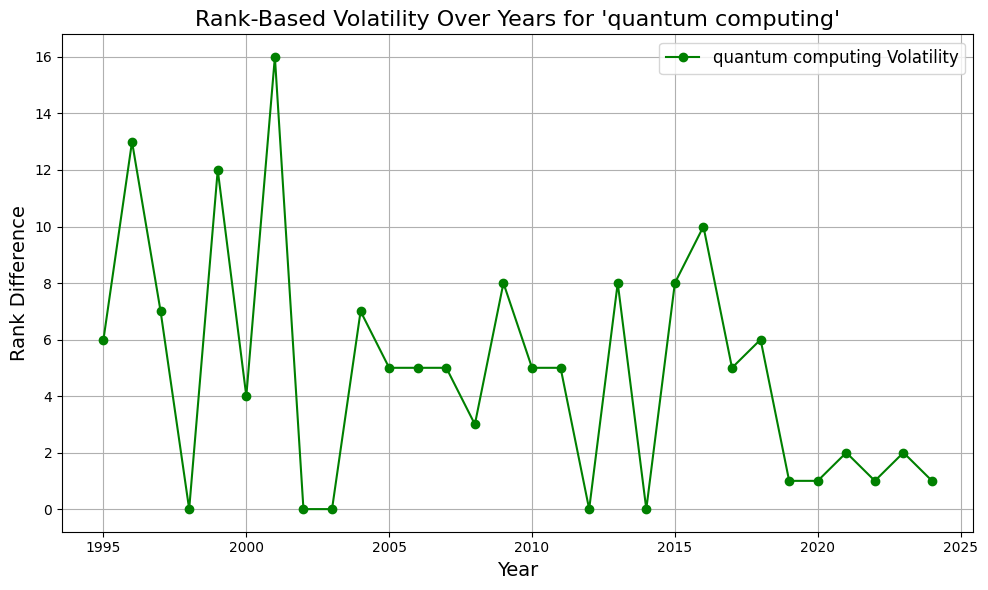

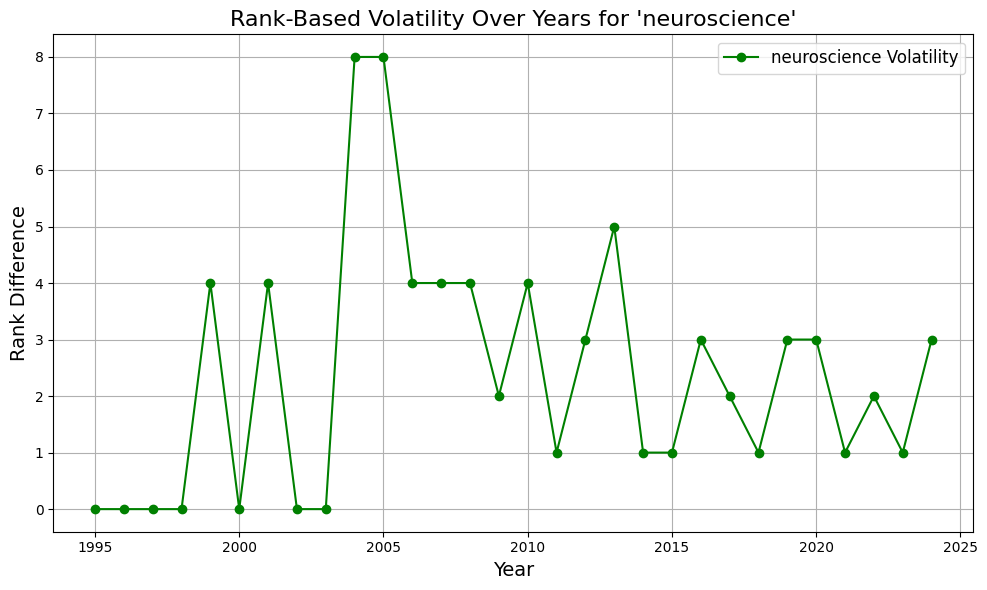

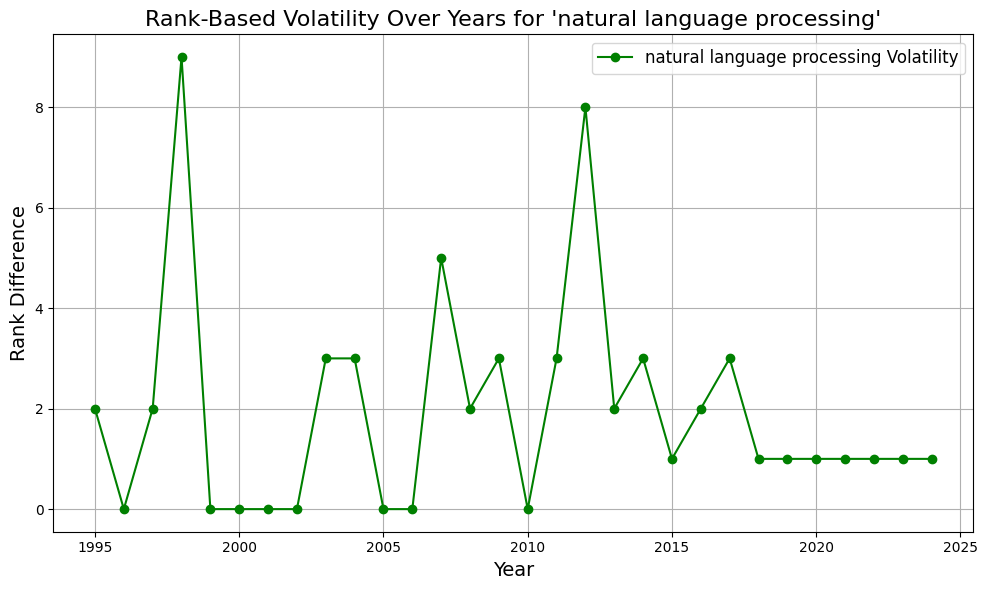

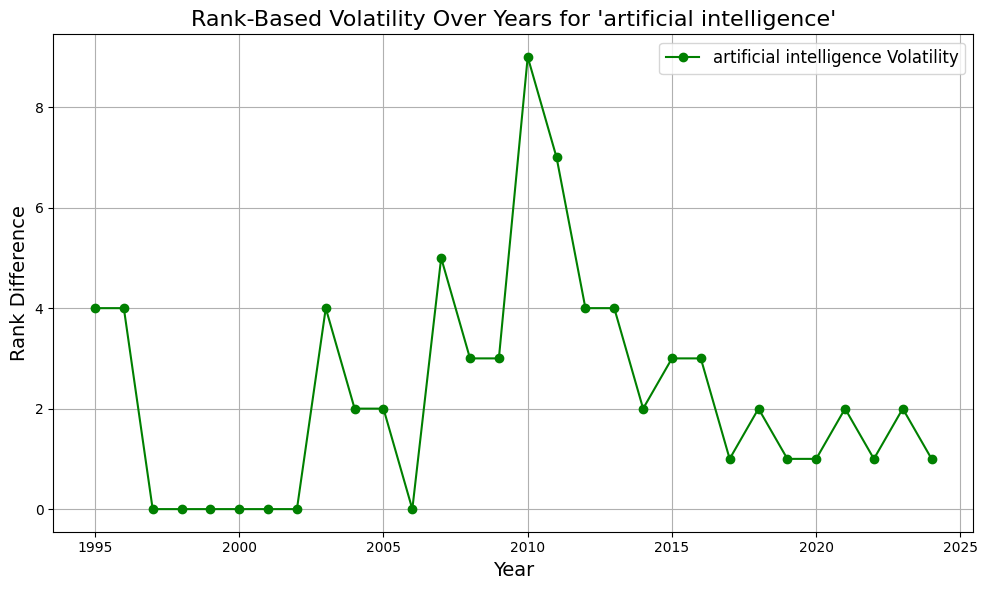

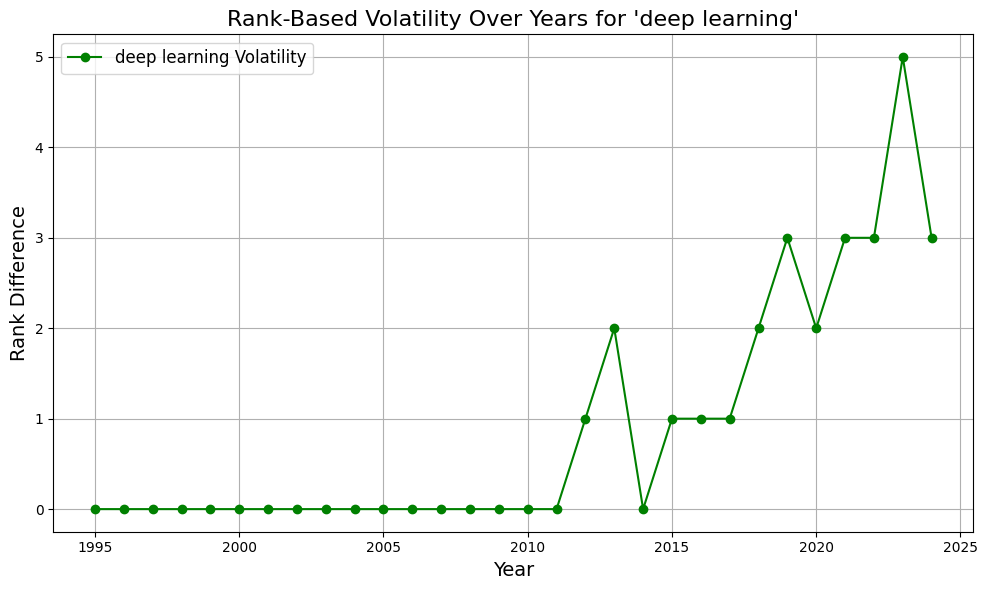

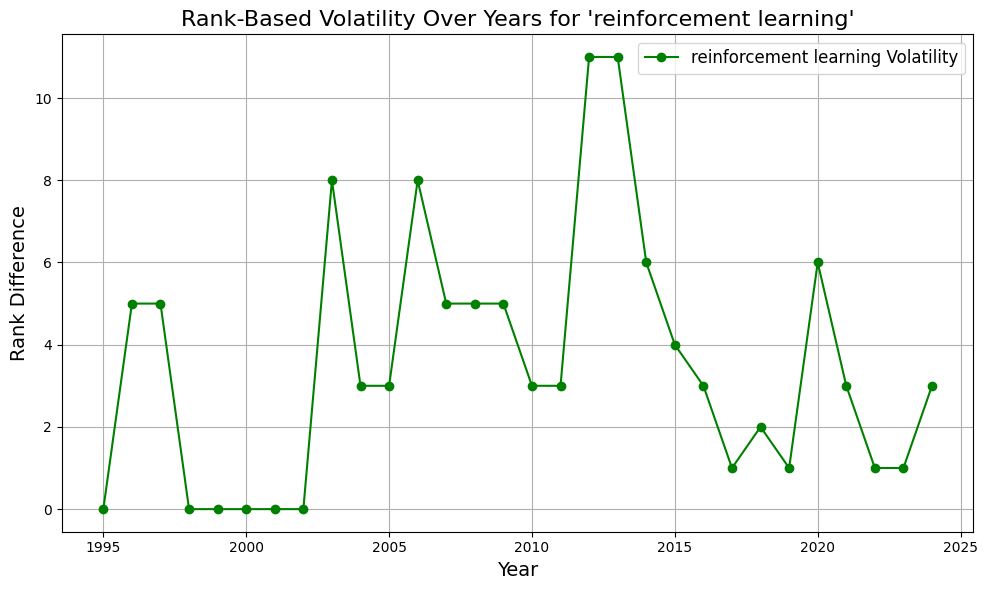

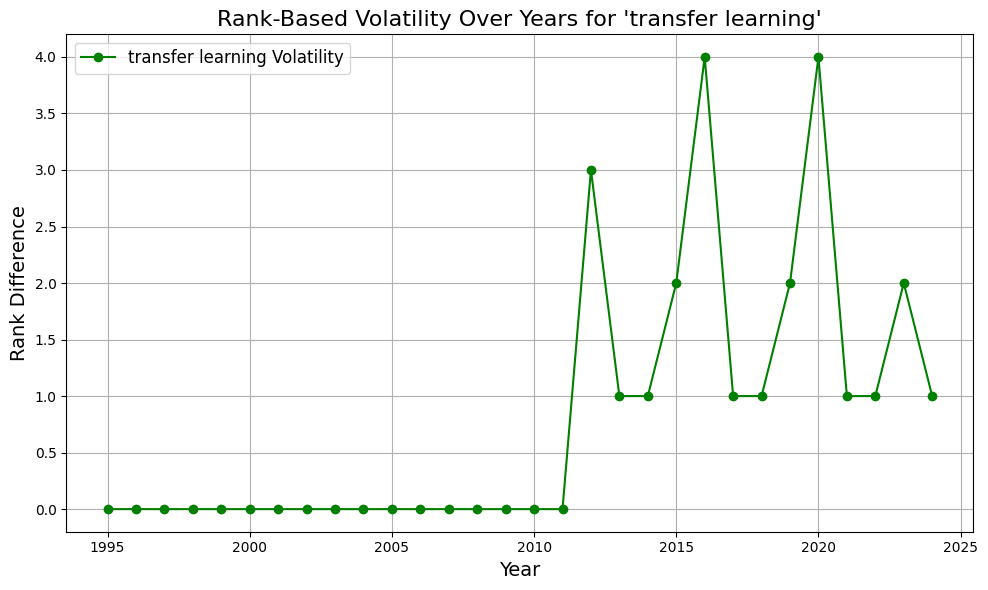

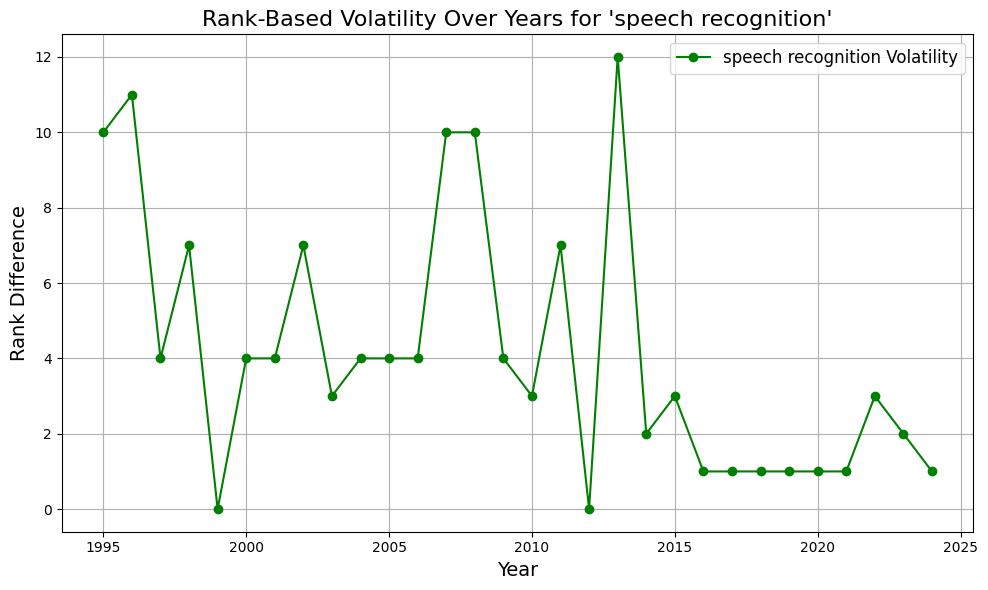

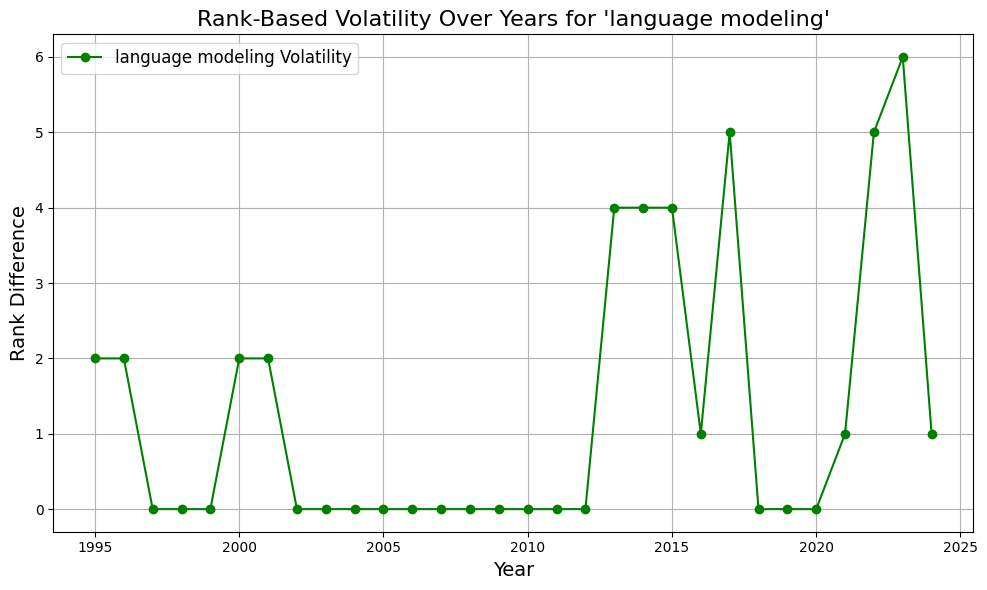

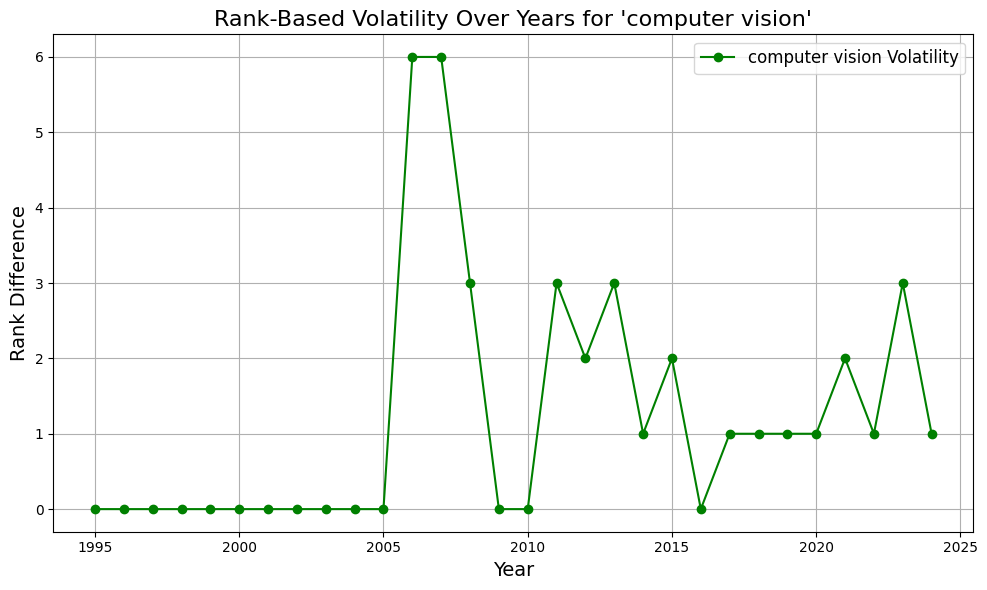

In [ ]:
for term in terms_of_interest:
    ranks = term_frequencies_df[term].rank(method="min", ascending=False)

    rank_diff = ranks.diff().abs()

    plt.figure(figsize=(10, 6))
    plt.plot(rank_diff.index, rank_diff.values, marker='o', label=f"{term} Volatility", color='green')


    plt.title(f"Rank-Based Volatility Over Years for '{term}'", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Rank Difference", fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()


    plt.show()


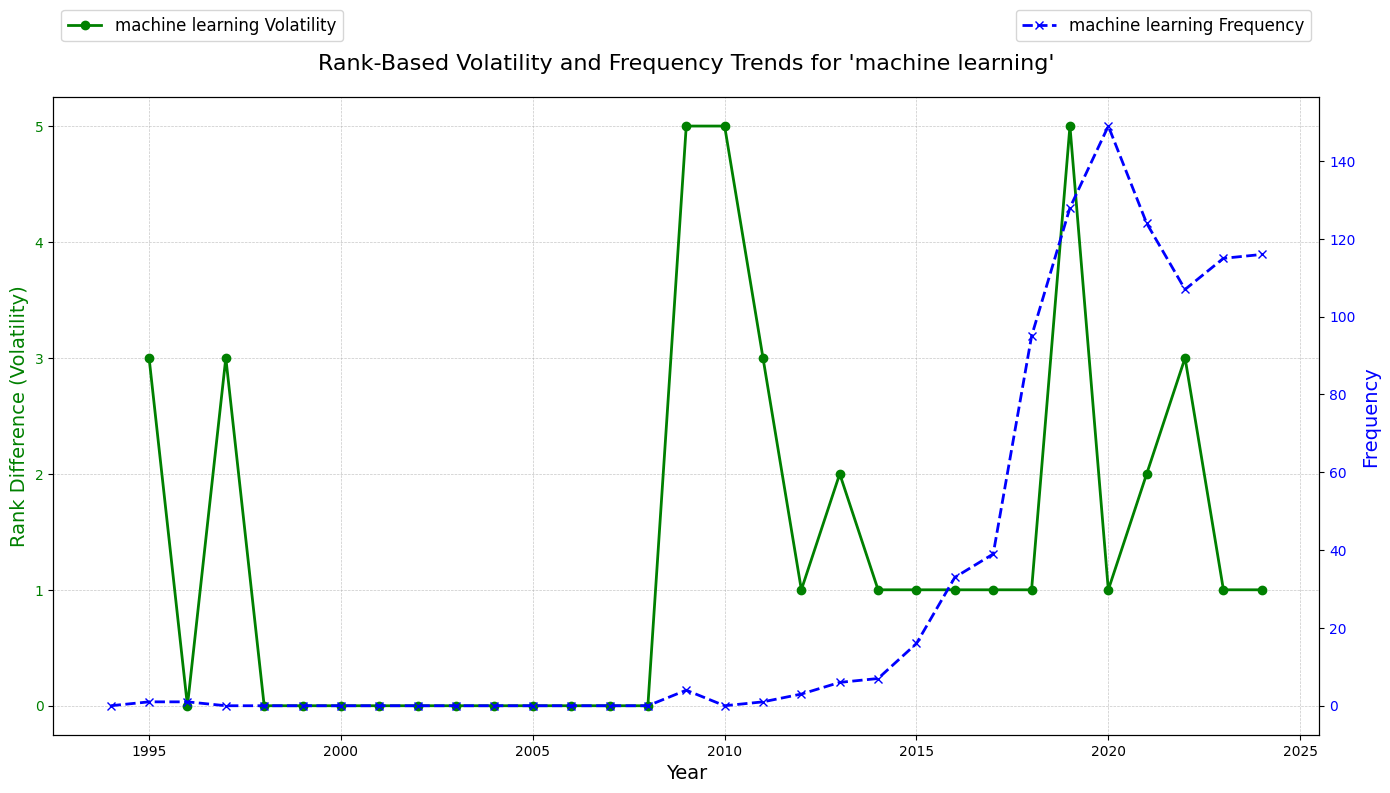

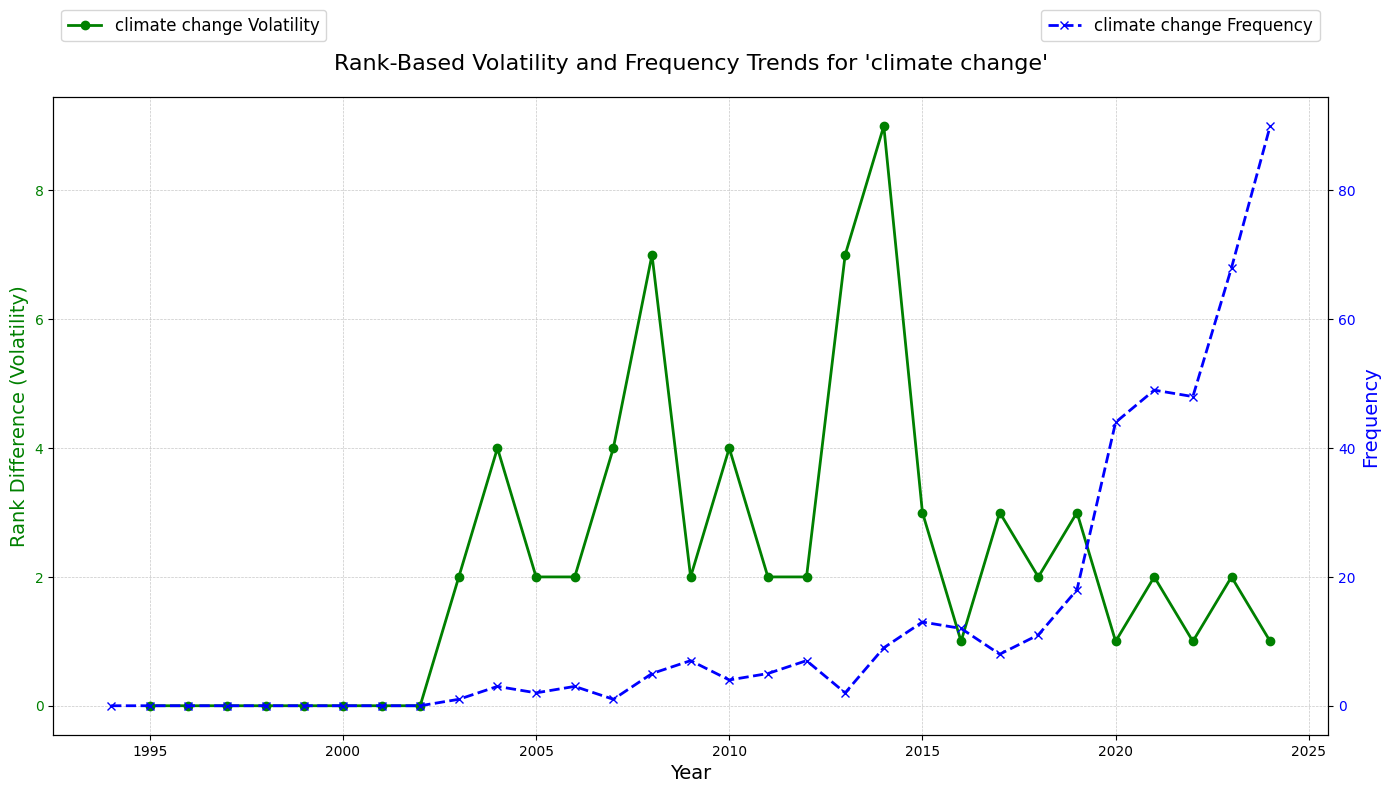

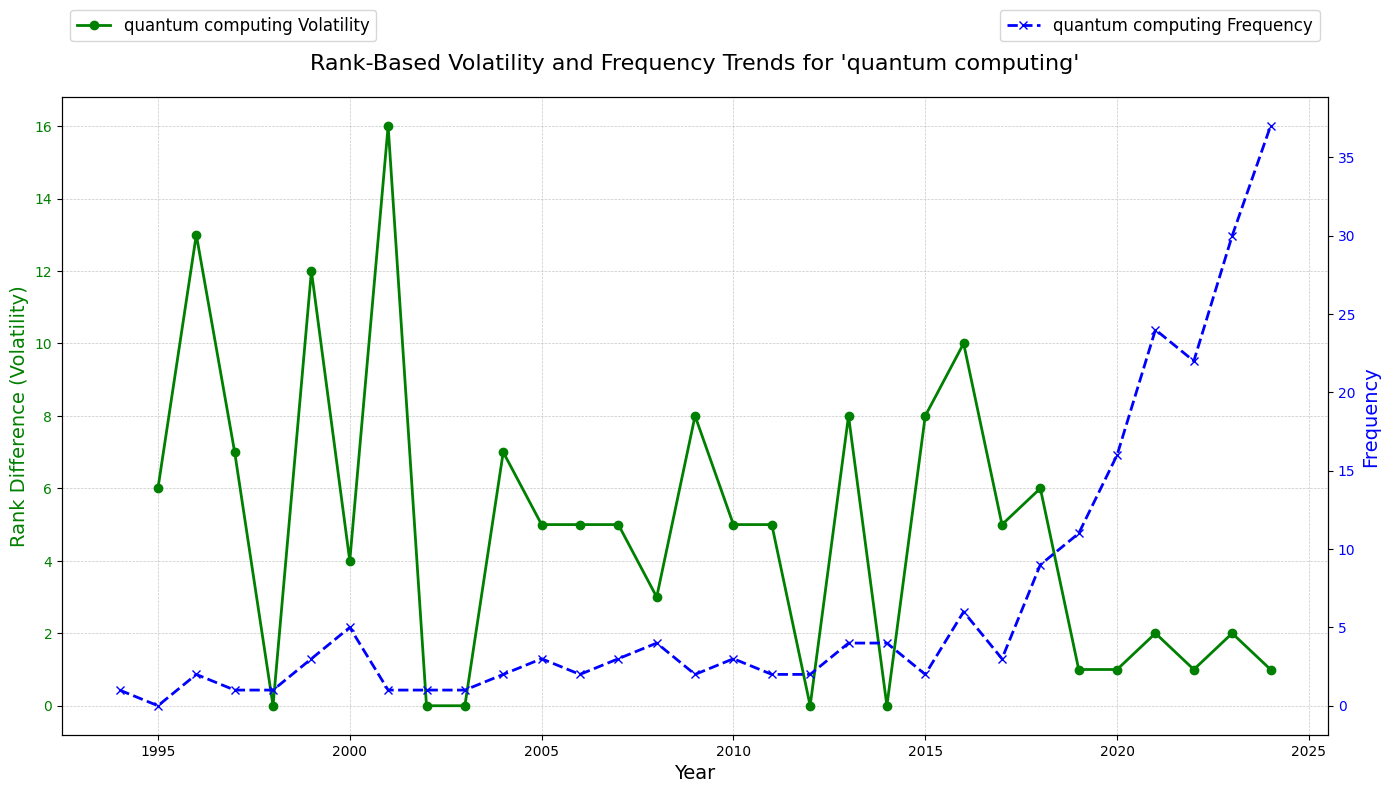

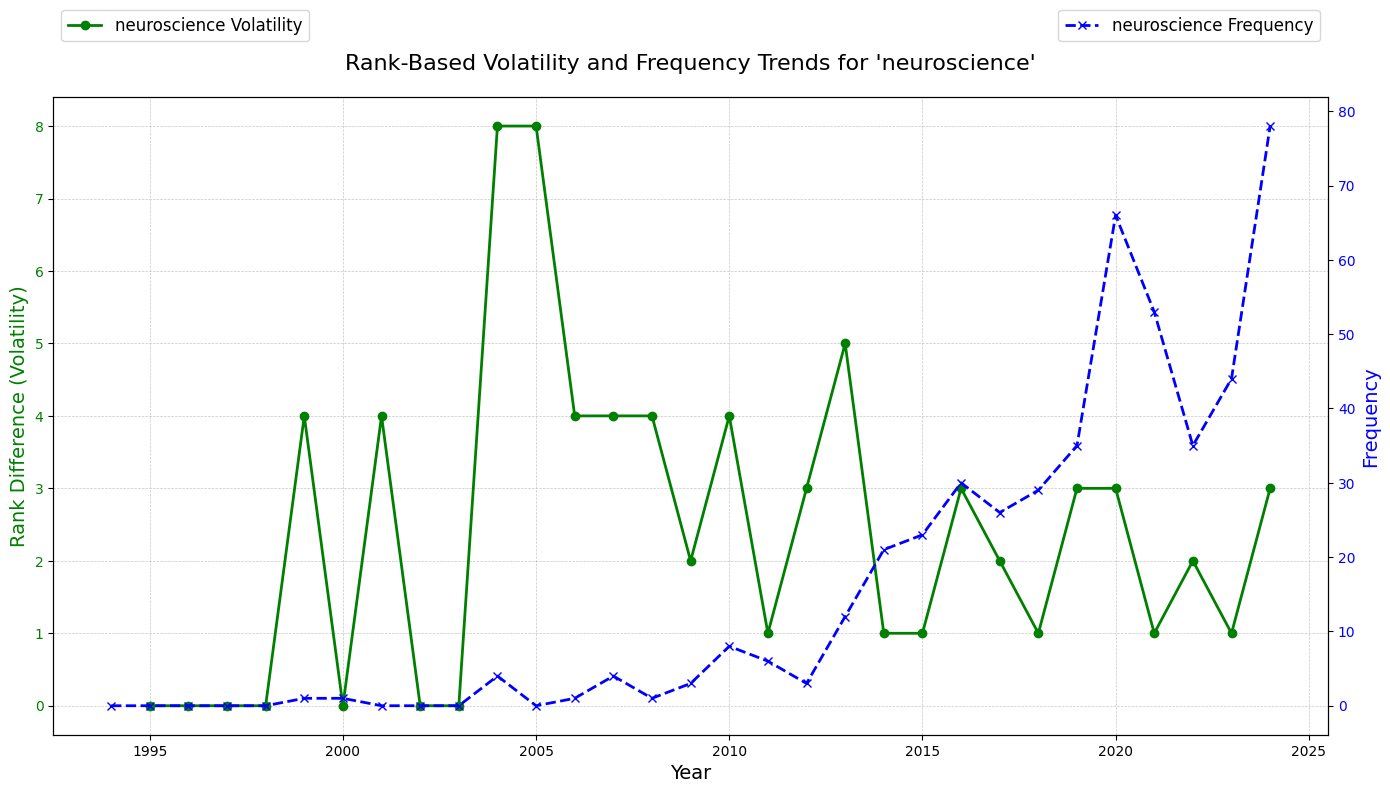

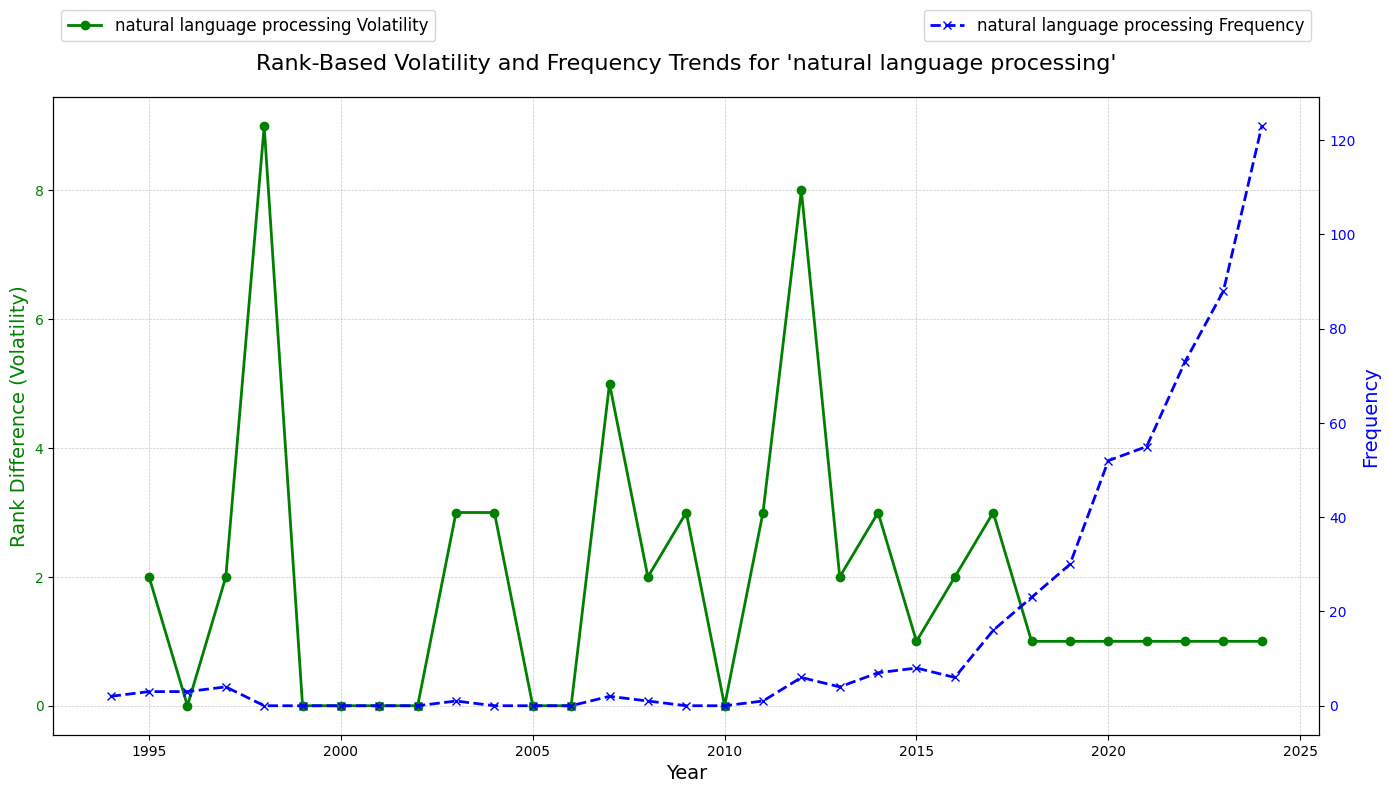

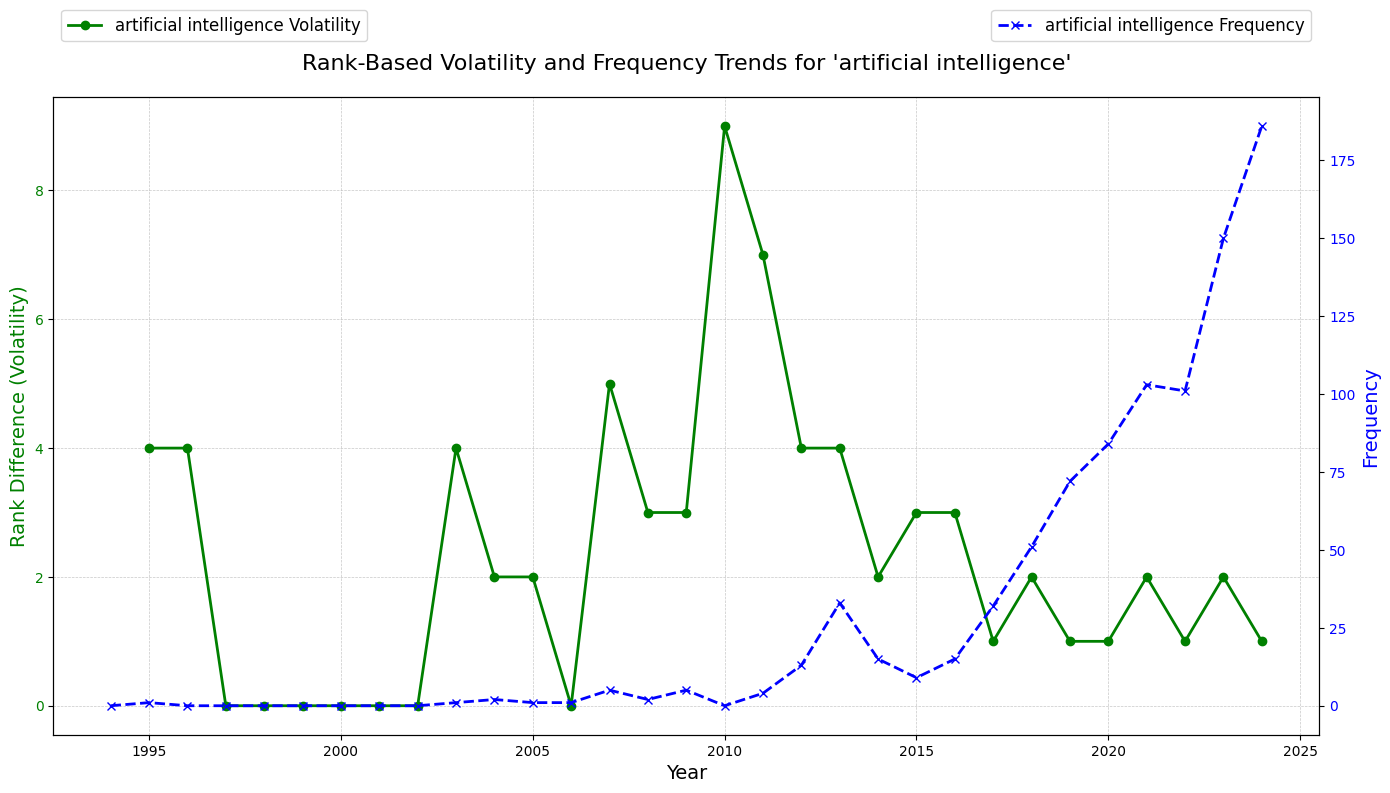

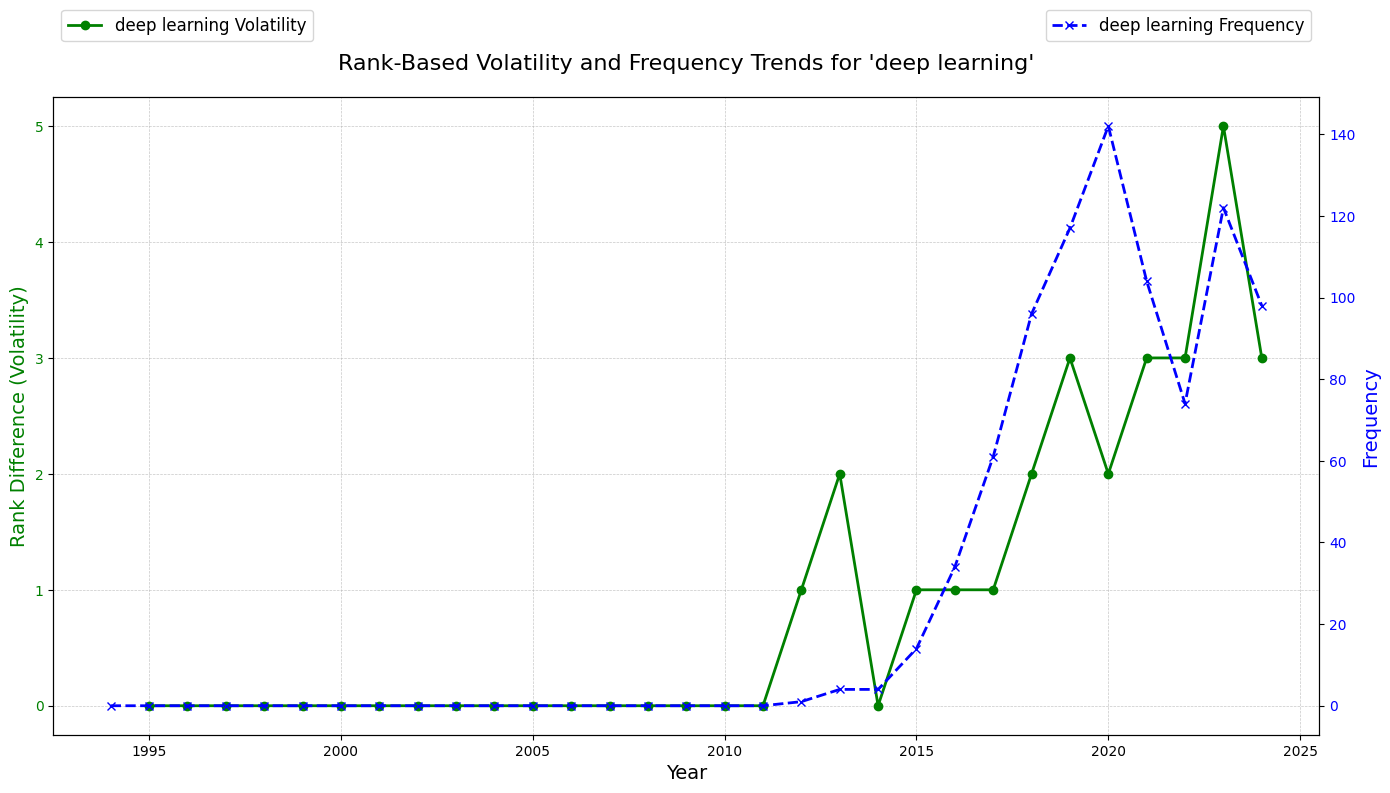

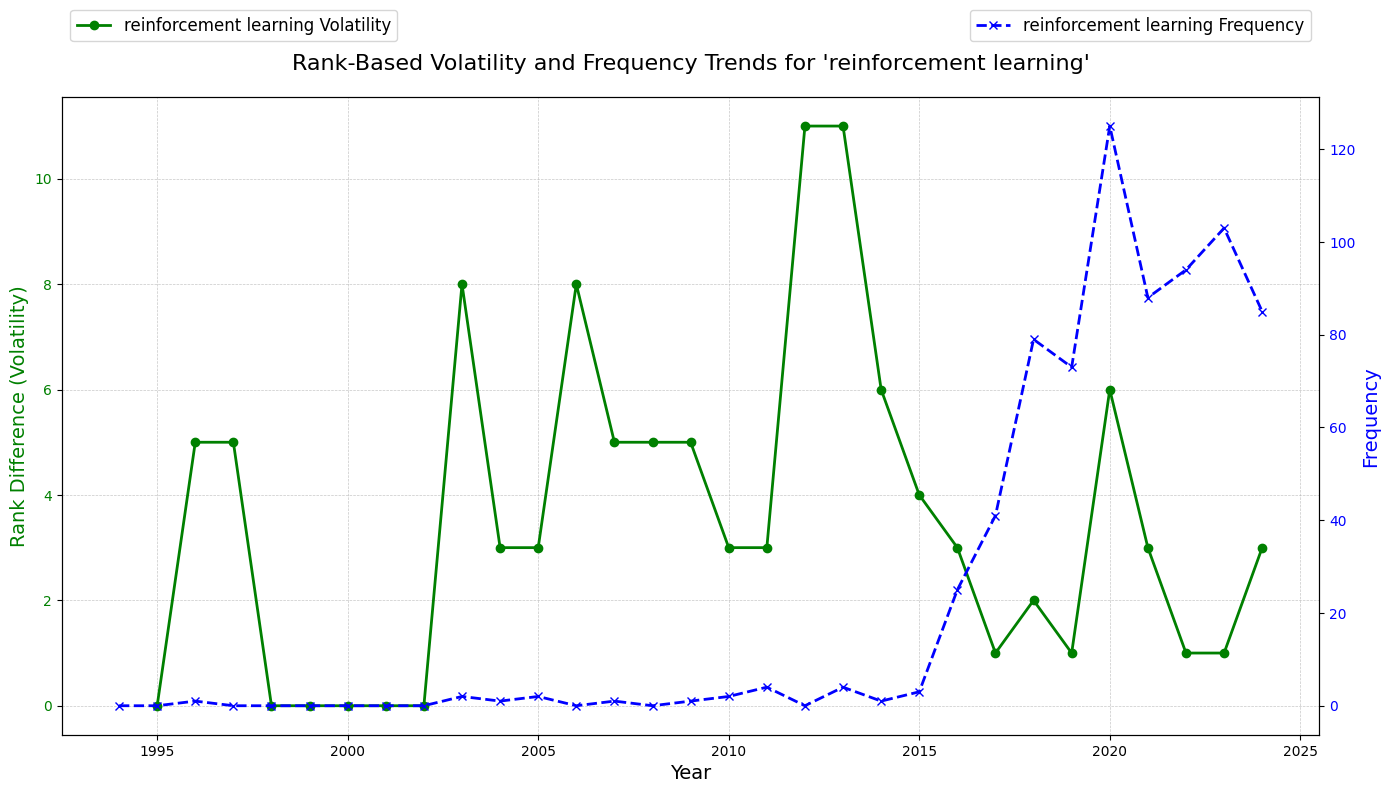

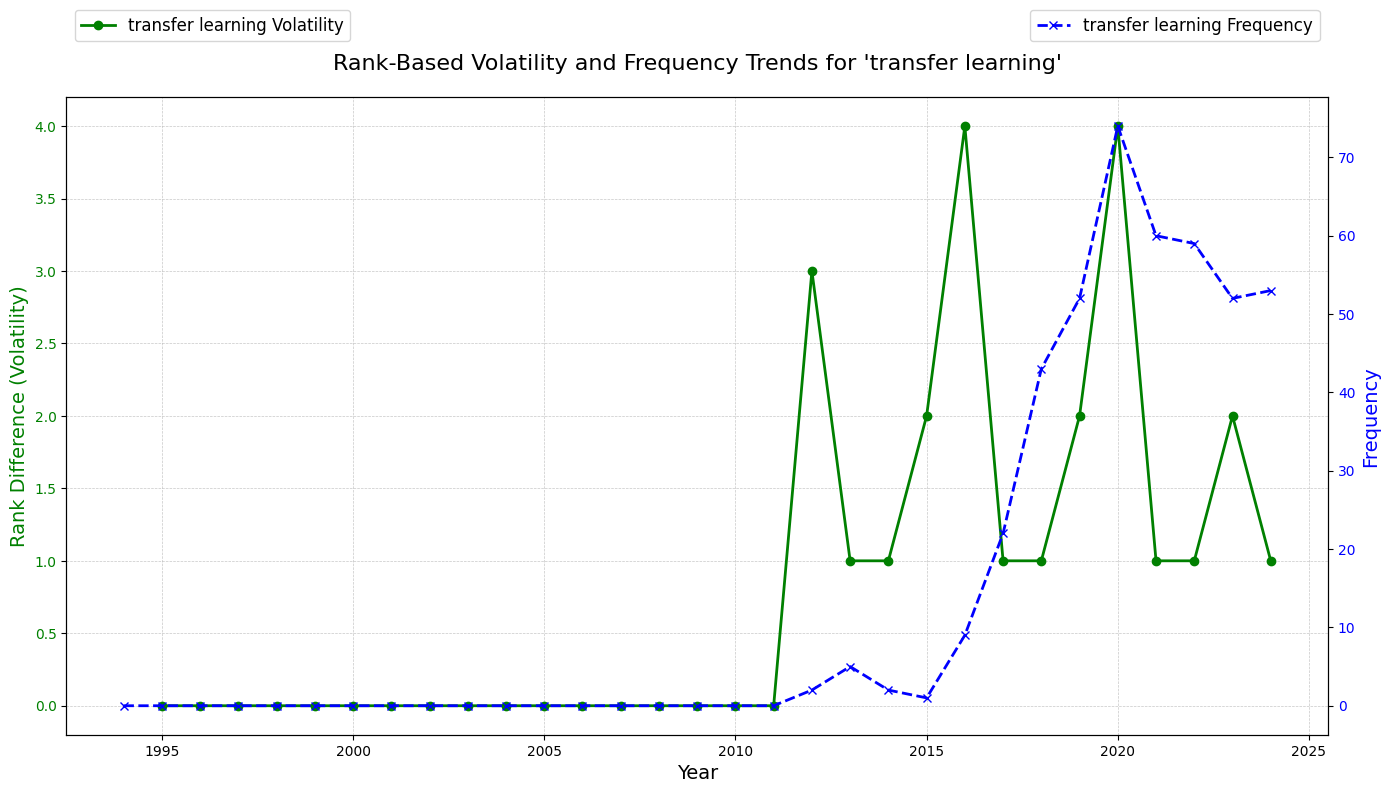

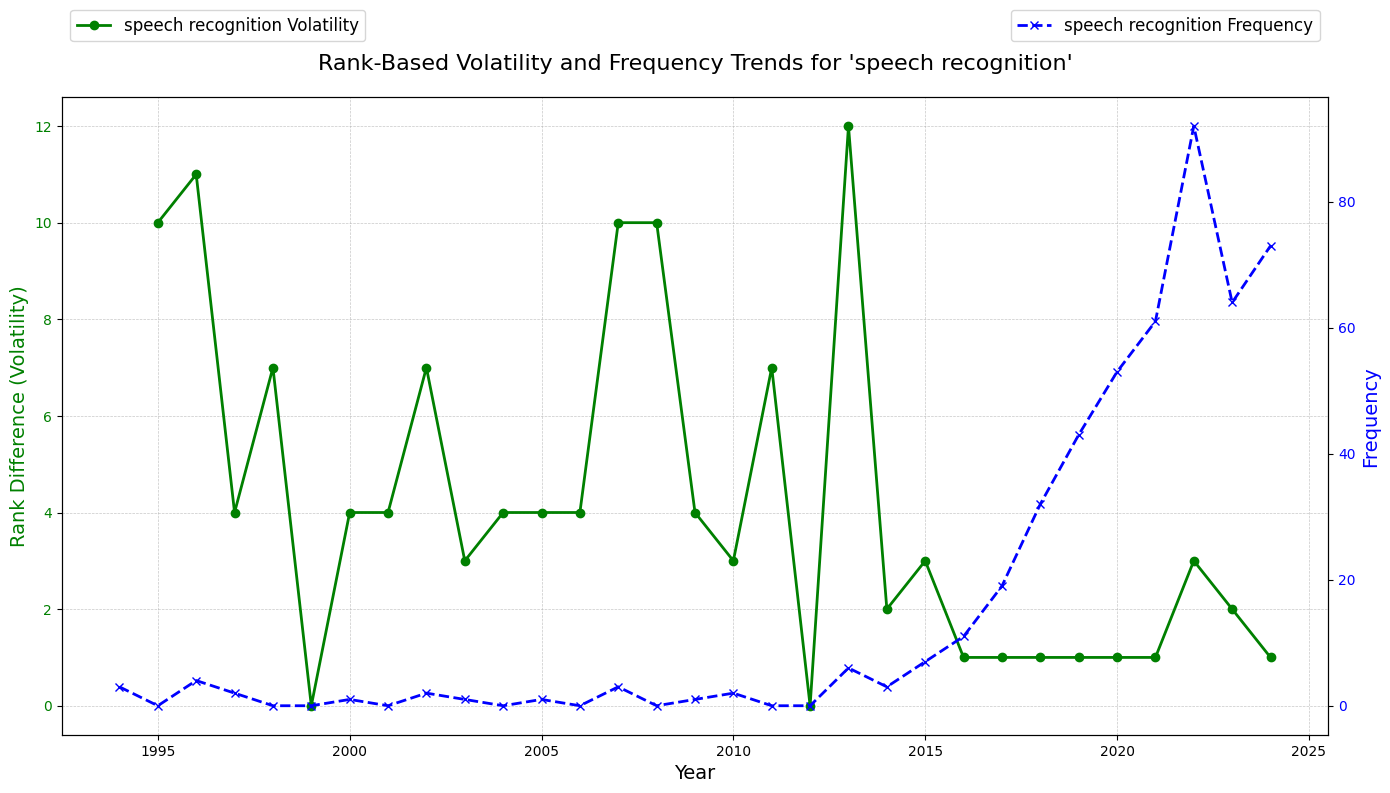

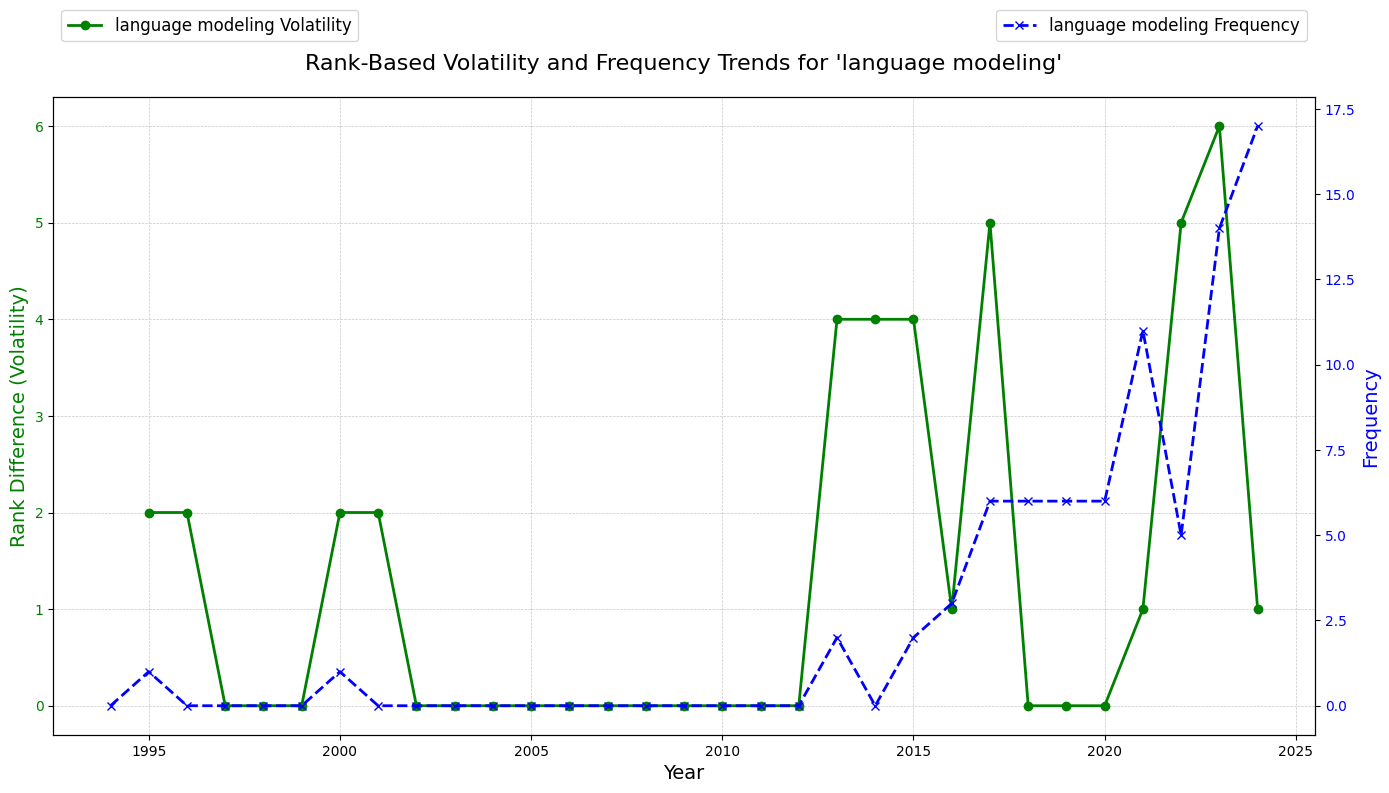

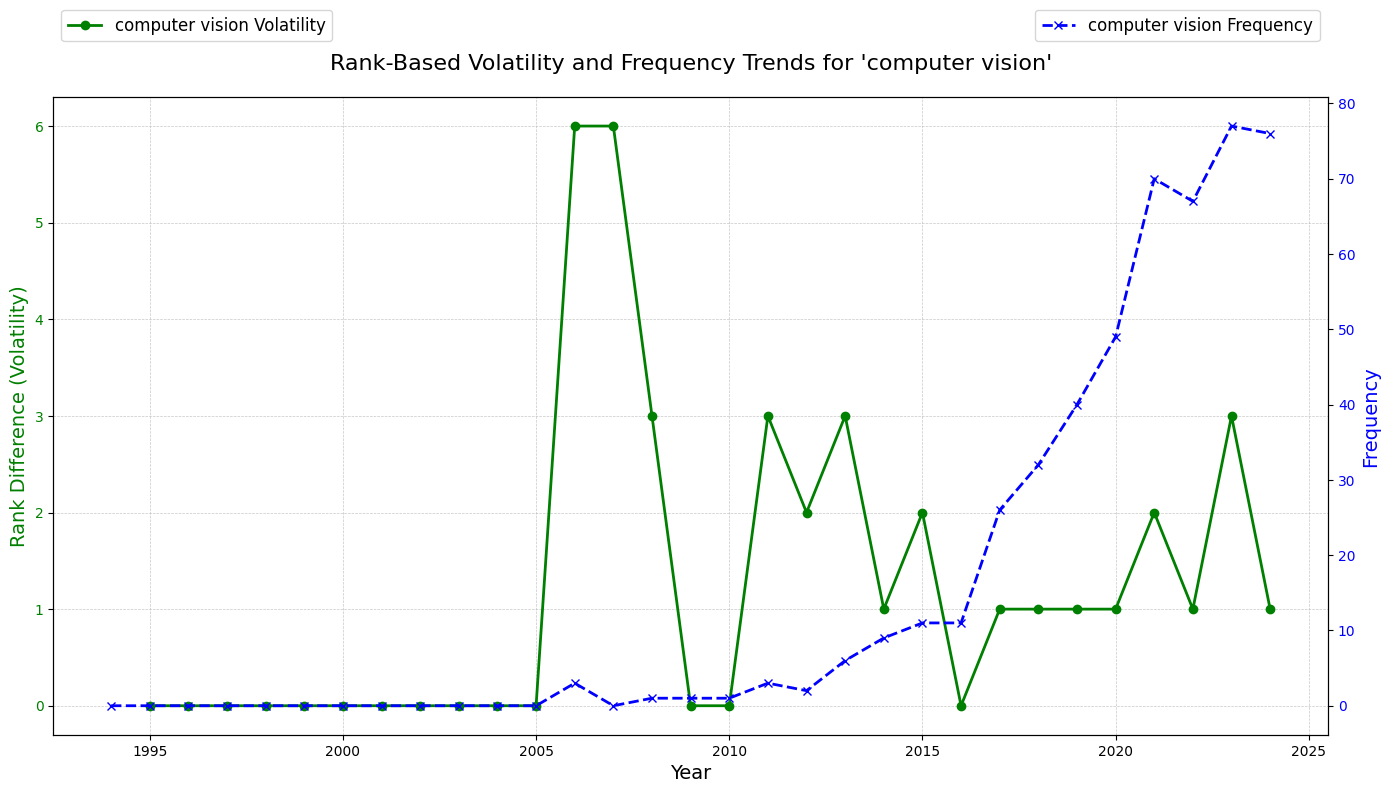

In [ ]:
def improved_plot_rank_based_volatility(term, term_frequencies_df):
    ranks = term_frequencies_df[term].rank(method="min", ascending=False)

    rank_diff = ranks.diff().abs()

    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax1.plot(
        rank_diff.index,
        rank_diff.values,
        marker='o',
        label=f"{term} Volatility",
        color='green',
        linewidth=2
    )
    ax1.set_xlabel("Year", fontsize=14)
    ax1.set_ylabel("Rank Difference (Volatility)", fontsize=14, color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    ax2 = ax1.twinx()
    ax2.plot(
        term_frequencies_df[term].index,
        term_frequencies_df[term].values,
        marker='x',
        linestyle='--',
        color='blue',
        label=f"{term} Frequency",
        linewidth=2
    )
    ax2.set_ylabel("Frequency", fontsize=14, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax1.legend(loc="upper left", fontsize=12, bbox_to_anchor=(0, 1.15))
    ax2.legend(loc="upper right", fontsize=12, bbox_to_anchor=(1, 1.15))

    plt.title(
        f"Rank-Based Volatility and Frequency Trends for '{term}'",
        fontsize=16,
        pad=20
    )

    plt.tight_layout()
    plt.show()

for term in terms_of_interest:
    improved_plot_rank_based_volatility(term, term_frequencies_df)


In [ ]:
# Calculate percentile-based thresholds for frequency
frequency_percentile = term_frequencies_df.mean().quantile(0.2)  # Lower percentile for weak signal detection


weak_signals = []

for term in terms_of_interest:
    term_frequency = term_frequencies_df[term]
    ranks = term_frequency.rank(method="min", ascending=False)
    rank_diff = ranks.diff().abs()
    rank_based_volatility = rank_diff.mean()

    avg_frequency = term_frequency.mean()

    print(f"Term: {term}")
    print(f"  Average Frequency: {avg_frequency}")
    print(f"  Rank-Based Volatility: {rank_based_volatility}")

    # Detect weak signals based on adjusted criteria
    if avg_frequency < frequency_percentile and rank_based_volatility > 2:
        weak_signals.append({
            "Term": term,
            "Average Frequency": avg_frequency,
            "Rank-Based Volatility": rank_based_volatility
        })

weak_signals_df = pd.DataFrame(weak_signals)

print("\nWeak Signals Detected:")
print(weak_signals_df)


Term: machine learning
  Average Frequency: 30.483870967741936
  Rank-Based Volatility: 1.3333333333333333
Term: climate change
  Average Frequency: 13.225806451612904
  Rank-Based Volatility: 2.2
Term: quantum computing
  Average Frequency: 6.67741935483871
  Rank-Based Volatility: 4.866666666666666
Term: neuroscience
  Average Frequency: 15.612903225806452
  Rank-Based Volatility: 2.4
Term: natural language processing
  Average Frequency: 16.387096774193548
  Rank-Based Volatility: 1.9333333333333333
Term: artificial intelligence
  Average Frequency: 28.580645161290324
  Rank-Based Volatility: 2.3333333333333335
Term: deep learning
  Average Frequency: 28.096774193548388
  Rank-Based Volatility: 0.9
Term: reinforcement learning
  Average Frequency: 23.70967741935484
  Rank-Based Volatility: 3.533333333333333
Term: transfer learning
  Average Frequency: 14.0
  Rank-Based Volatility: 0.8
Term: speech recognition
  Average Frequency: 15.612903225806452
  Rank-Based Volatility: 4.1666666

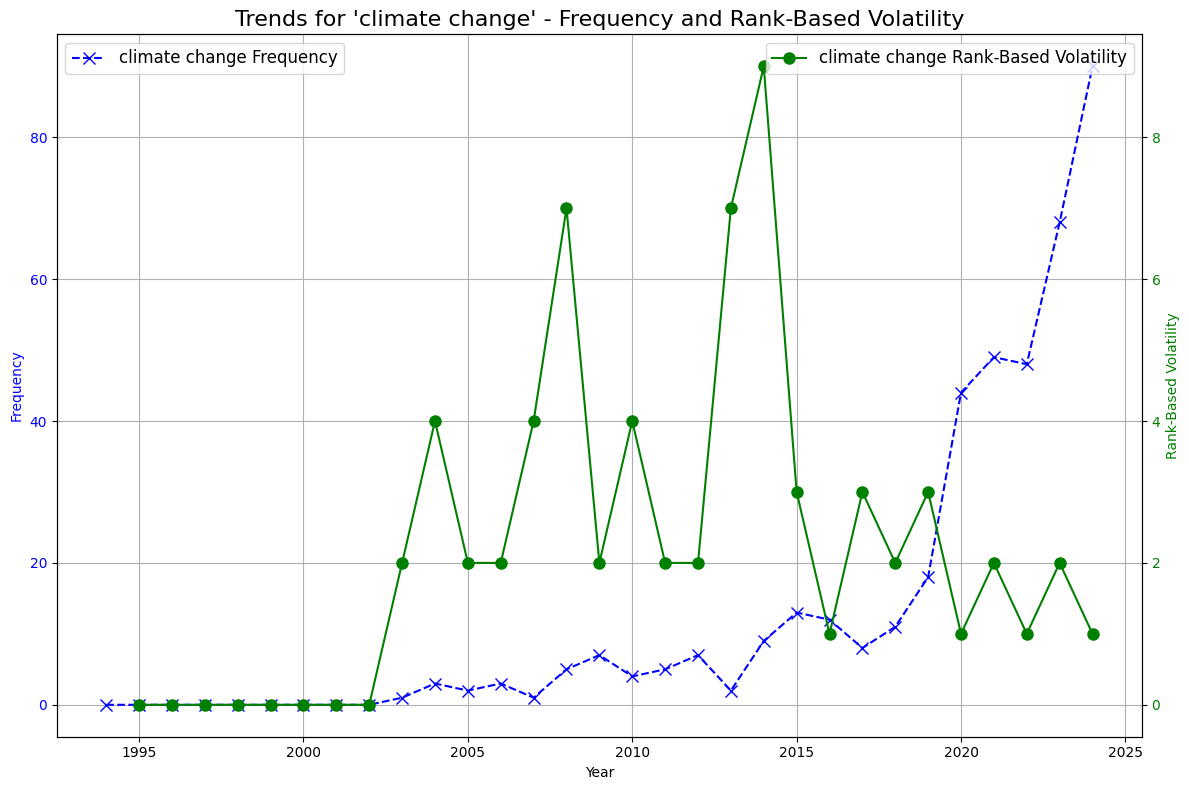

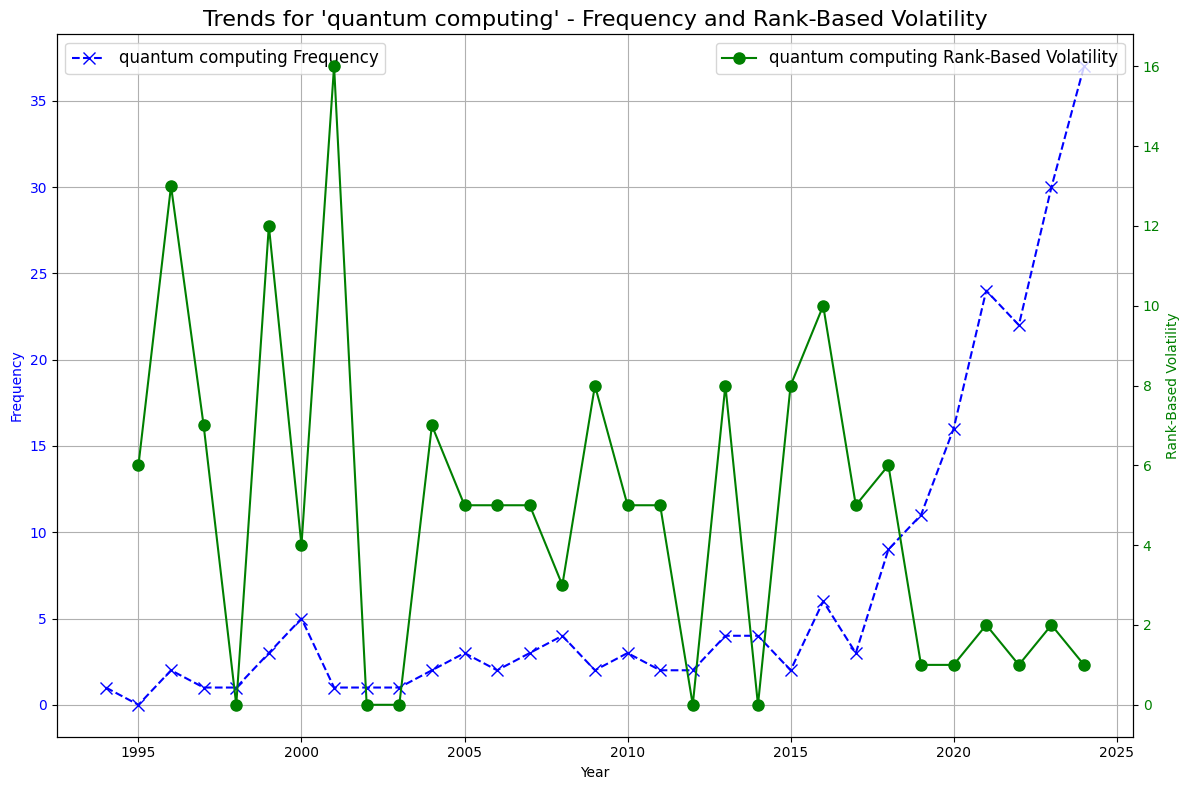

In [ ]:
import matplotlib.pyplot as plt

def plot_weak_signal_trends(weak_signals, term_frequencies_df):
    for term in weak_signals['Term']:
        term_data = term_frequencies_df[term]
        rank_volatility = term_data.rank(method="min", ascending=False).diff().abs()

        fig, ax1 = plt.subplots(figsize=(12, 8))


        ax1.plot(term_data.index, term_data.values, 'b--x', label=f"{term} Frequency", markersize=8)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Frequency', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')


        ax2 = ax1.twinx()
        ax2.plot(rank_volatility.index, rank_volatility.values, 'g-o', label=f"{term} Rank-Based Volatility", markersize=8)
        ax2.set_ylabel('Rank-Based Volatility', color='green')
        ax2.tick_params(axis='y', labelcolor='green')


        plt.title(f"Trends for '{term}' - Frequency and Rank-Based Volatility", fontsize=16)
        ax1.grid(True)


        ax1.legend(loc='upper left', fontsize=12)
        ax2.legend(loc='upper right', fontsize=12)


        plt.tight_layout()
        plt.show()


plot_weak_signal_trends(weak_signals_df, term_frequencies_df)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


term = 'machine learning'
data = term_frequencies_df[term].values
data = data.reshape(-1, 1)

scaler_freq = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler_freq.fit_transform(data)

# Prepare the data for LSTM
look_back = 5

def create_dataset(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back):
        x.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

x_data, y_data = create_dataset(scaled_data, look_back)


x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(x_data.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train the model
model = create_model()
model.fit(x_data, y_data, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.1991
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1885
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1783
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1687
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1596
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1509
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1427
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1349
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1275
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1205
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1139
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1076
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1017
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0961
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0908
Epoch 16/50
1/1 ━━━━━━━━

In [ ]:
# Function to make future predictions
def predict_future(model, data, look_back, steps=5):
    predictions = []
    last_data = data[-look_back:].reshape(1, look_back, 1)  # Get the last 5 data points

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])
        last_data = np.roll(last_data, -1, axis=1)  # Shift the data
        last_data[0, -1, 0] = pred  # Add the new prediction

    return np.array(predictions)

# Make predictions for the next 5 years
future_freq = predict_future(model, scaled_data, look_back, steps=5)

# Inverse transform the predictions to get the original scale
future_freq = scaler_freq.inverse_transform(future_freq.reshape(-1, 1))

# Print the future frequency predictions
print("Predicted Frequencies for next 5 years:")
for year, freq in zip(range(2025, 2030), future_freq.flatten()):
    print(f"Year {year}: Predicted Frequency: {freq:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


<ipython-input-150-b36de60f71c7>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Frequencies for next 5 years:
Year 2025: Predicted Frequency: 129.86
Year 2026: Predicted Frequency: 124.80
Year 2027: Predicted Frequency: 125.45
Year 2028: Predicted Frequency: 129.65
Year 2029: Predicted Frequency: 132.66


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Predicted Frequencies for 'machine learning' for the next 5 years:
Year 2025: Predicted Frequency: 129.86
Year 2026: Predicted Frequency: 124.80
Year 2027: Predicted Frequency: 125.45
Year 2028: Predicted Frequency: 129.65
Year 2029: Predicted Frequency: 132.66


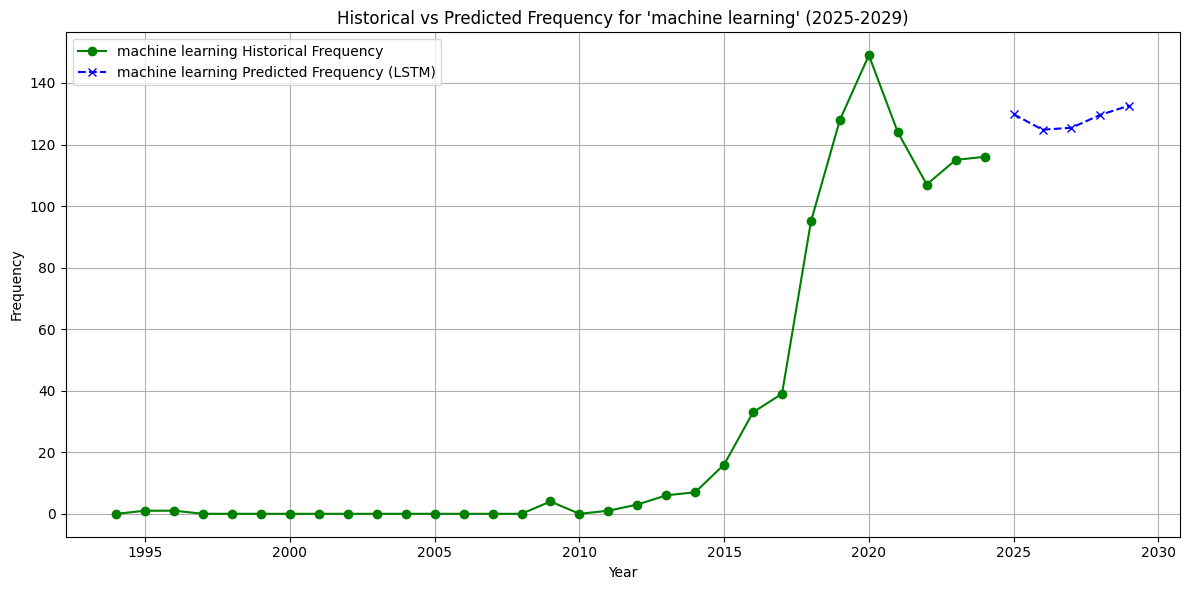

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

Predicted Frequencies for 'climate change' for the next 5 years:
Year 2025: Predicted Frequency: 65.74
Year 2026: Predicted Frequency: 71.79
Year 2027: Predicted Frequency: 76.68
Year 2028: Predicted Frequency: 81.81
Year 2029: Predicted Frequency: 83.87


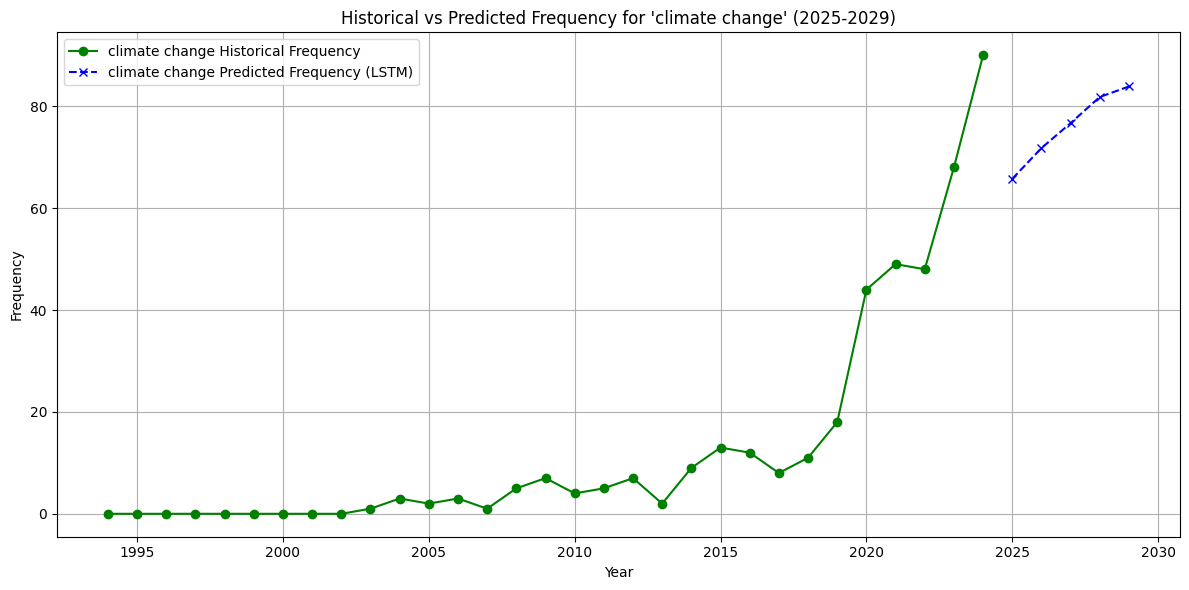

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Predicted Frequencies for 'quantum computing' for the next 5 years:
Year 2025: Predicted Frequency: 37.04
Year 2026: Predicted Frequency: 40.84
Year 2027: Predicted Frequency: 43.87
Year 2028: Predicted Frequency: 47.70
Year 2029: Predicted Frequency: 50.74


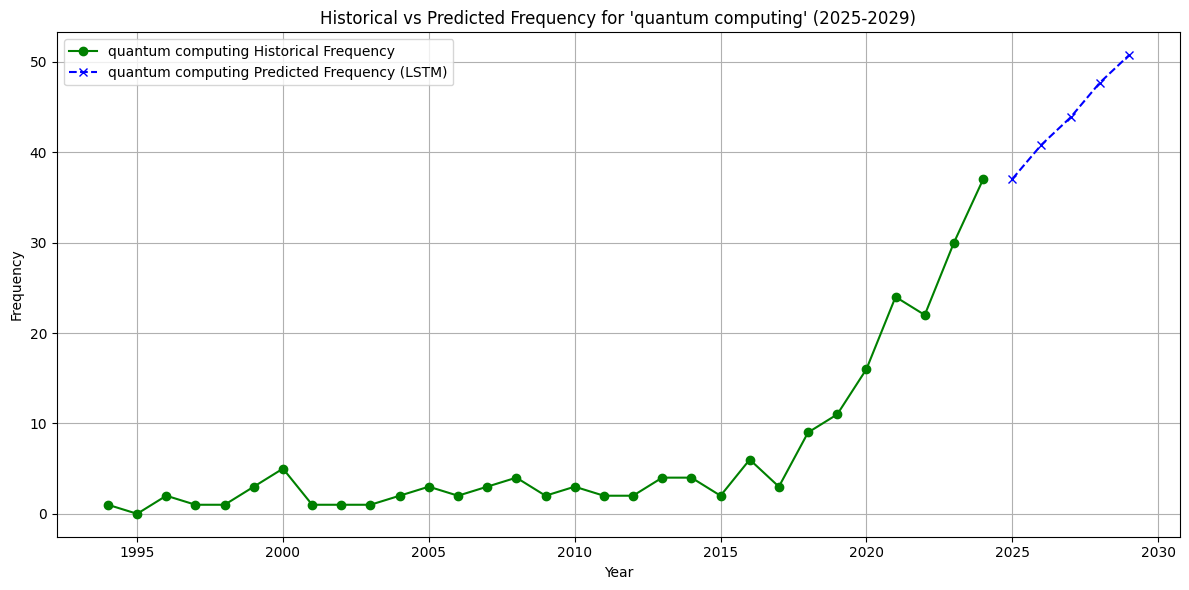

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Predicted Frequencies for 'neuroscience' for the next 5 years:
Year 2025: Predicted Frequency: 61.88
Year 2026: Predicted Frequency: 61.97
Year 2027: Predicted Frequency: 64.60
Year 2028: Predicted Frequency: 70.29
Year 2029: Predicted Frequency: 74.67


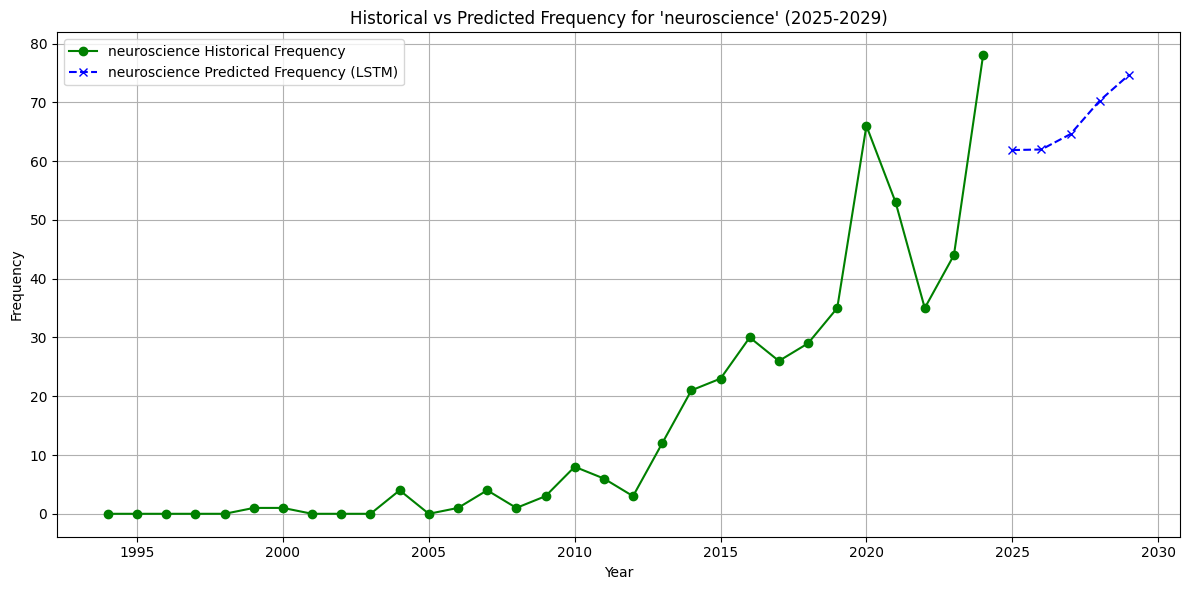

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Predicted Frequencies for 'natural language processing' for the next 5 years:
Year 2025: Predicted Frequency: 82.27
Year 2026: Predicted Frequency: 91.41
Year 2027: Predicted Frequency: 99.26
Year 2028: Predicted Frequency: 103.84
Year 2029: Predicted Frequency: 106.20


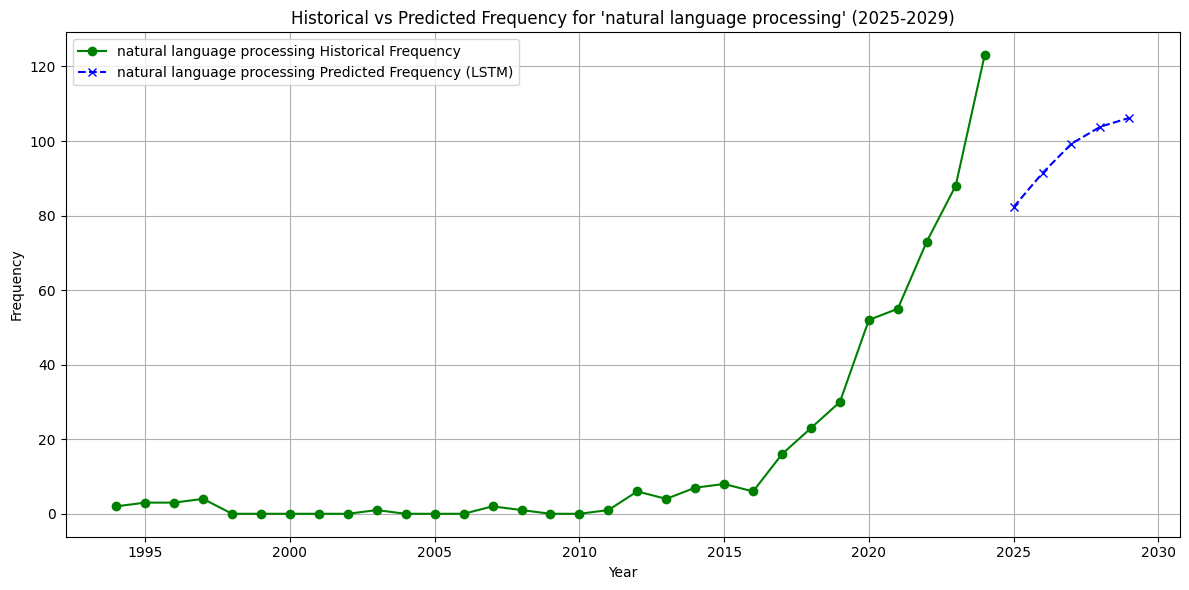

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Predicted Frequencies for 'artificial intelligence' for the next 5 years:
Year 2025: Predicted Frequency: 127.79
Year 2026: Predicted Frequency: 141.59
Year 2027: Predicted Frequency: 150.96
Year 2028: Predicted Frequency: 160.57
Year 2029: Predicted Frequency: 161.42


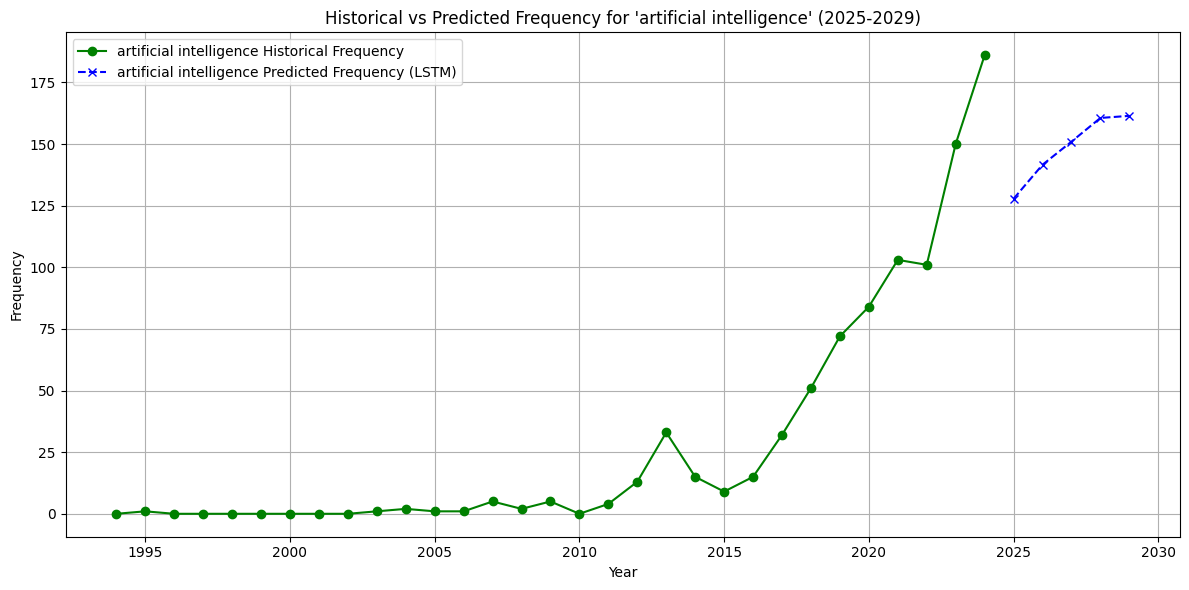

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Predicted Frequencies for 'deep learning' for the next 5 years:
Year 2025: Predicted Frequency: 114.88
Year 2026: Predicted Frequency: 108.79
Year 2027: Predicted Frequency: 110.54
Year 2028: Predicted Frequency: 117.91
Year 2029: Predicted Frequency: 116.81


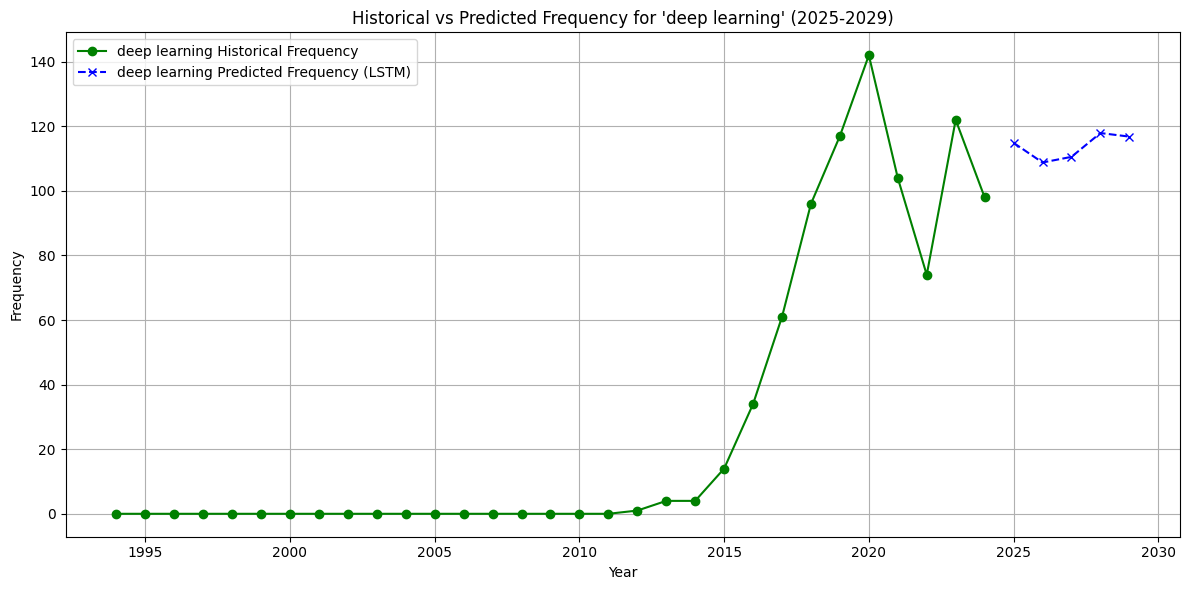

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Predicted Frequencies for 'reinforcement learning' for the next 5 years:
Year 2025: Predicted Frequency: 106.54
Year 2026: Predicted Frequency: 101.80
Year 2027: Predicted Frequency: 104.65
Year 2028: Predicted Frequency: 106.81
Year 2029: Predicted Frequency: 107.78


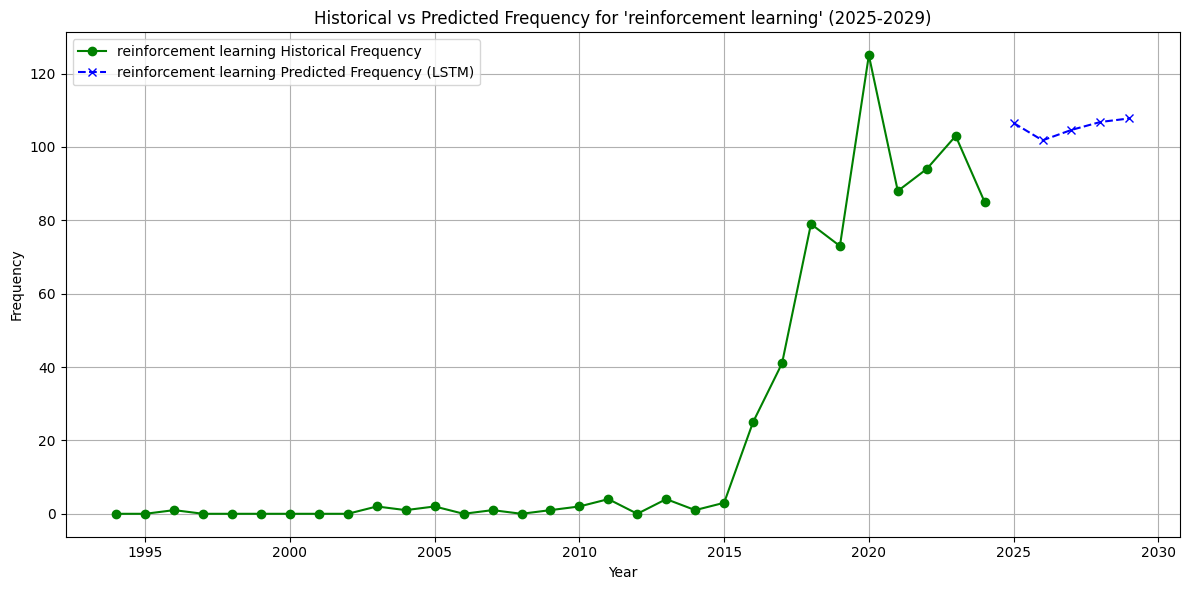

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Predicted Frequencies for 'transfer learning' for the next 5 years:
Year 2025: Predicted Frequency: 68.21
Year 2026: Predicted Frequency: 66.01
Year 2027: Predicted Frequency: 67.18
Year 2028: Predicted Frequency: 69.03
Year 2029: Predicted Frequency: 72.41


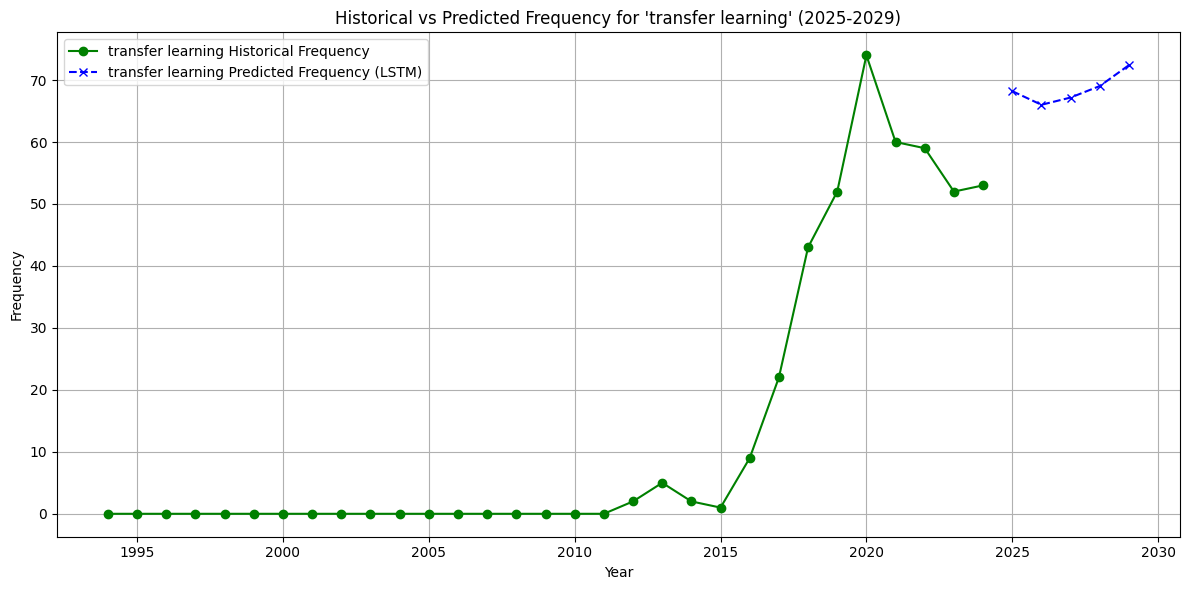

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Predicted Frequencies for 'speech recognition' for the next 5 years:
Year 2025: Predicted Frequency: 76.41
Year 2026: Predicted Frequency: 80.69
Year 2027: Predicted Frequency: 83.95
Year 2028: Predicted Frequency: 82.44
Year 2029: Predicted Frequency: 86.32


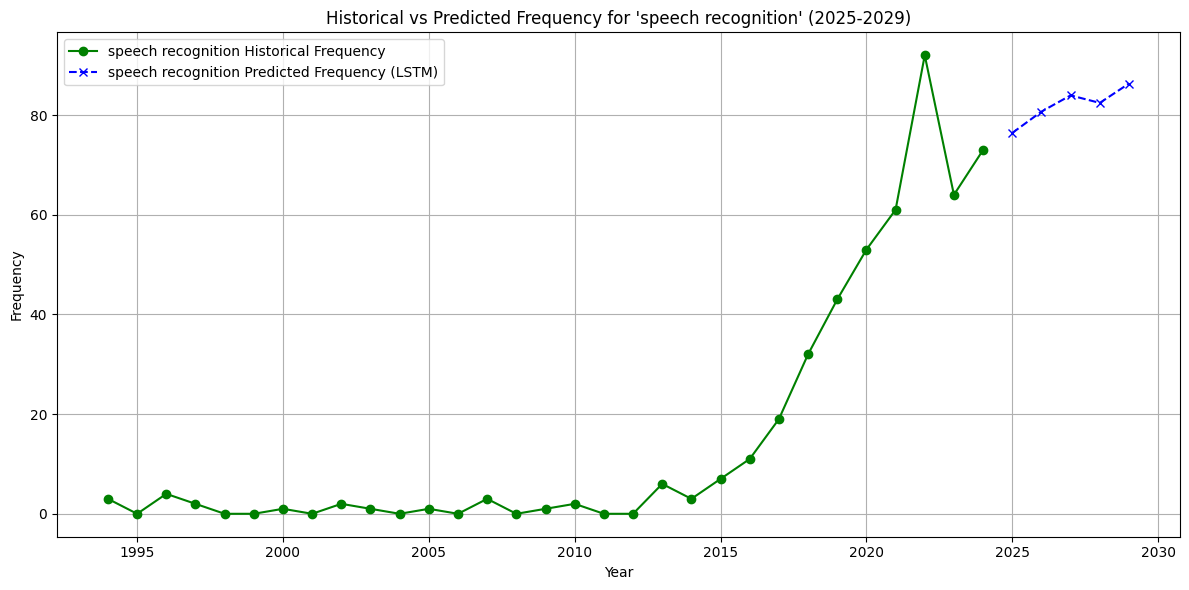

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Predicted Frequencies for 'language modeling' for the next 5 years:
Year 2025: Predicted Frequency: 24.82
Year 2026: Predicted Frequency: 27.56
Year 2027: Predicted Frequency: 30.40
Year 2028: Predicted Frequency: 34.76
Year 2029: Predicted Frequency: 38.27


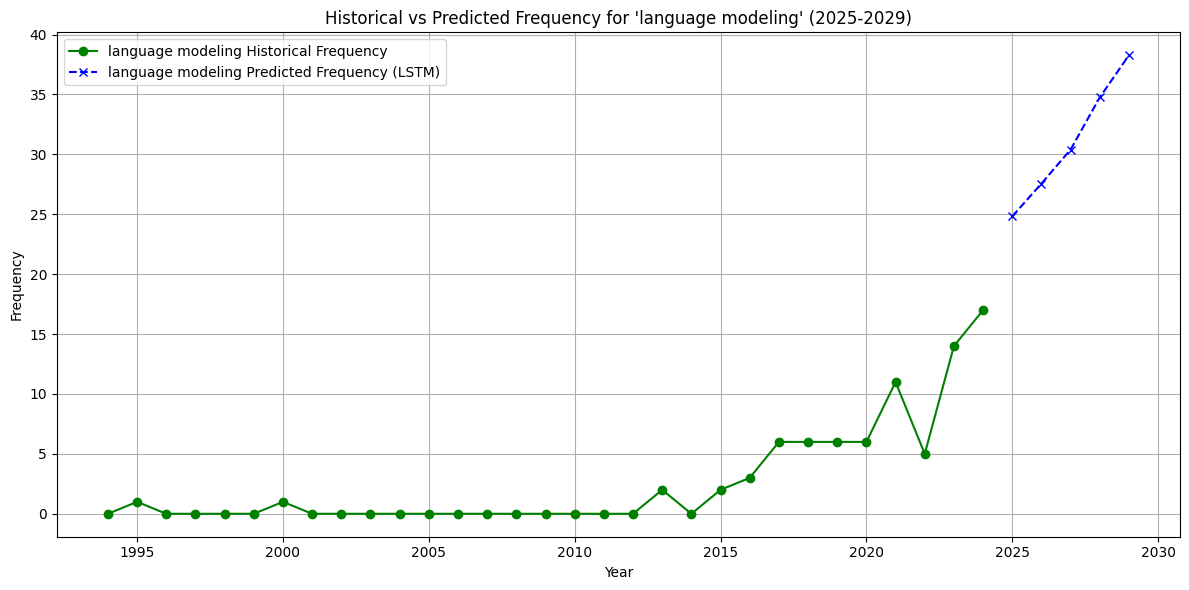

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-161-46853b29787d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Predicted Frequencies for 'computer vision' for the next 5 years:
Year 2025: Predicted Frequency: 75.05
Year 2026: Predicted Frequency: 80.32
Year 2027: Predicted Frequency: 82.19
Year 2028: Predicted Frequency: 85.02
Year 2029: Predicted Frequency: 86.54


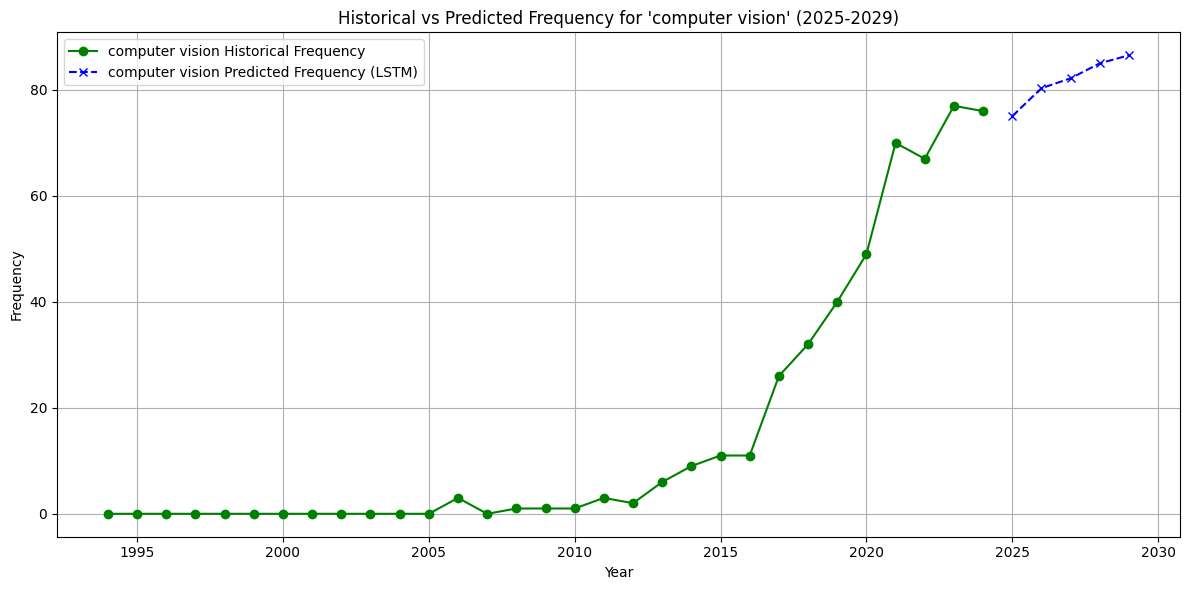

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to make future predictions
def predict_future(model, data, look_back, steps=5):
    predictions = []
    last_data = data[-look_back:].reshape(1, look_back, 1)  # Get the last 'look_back' data points

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])
        last_data = np.roll(last_data, -1, axis=1)  # Shift the data
        last_data[0, -1, 0] = pred  # Add the new prediction

    return np.array(predictions)

# Function to display the predictions for each term
def display_predictions_for_all_terms(terms_of_interest, term_frequencies_df, model, scaler_freq, look_back=5, steps=5):

    for term in terms_of_interest:

        historical_data = term_frequencies_df[term].values


        scaled_data = scaler_freq.transform(historical_data.reshape(-1, 1))


        future_freq = predict_future(model, scaled_data, look_back, steps=steps)

        future_freq = scaler_freq.inverse_transform(future_freq.reshape(-1, 1))


        print(f"\nPredicted Frequencies for '{term}' for the next 5 years:")
        for year, freq in zip(range(2025, 2030), future_freq.flatten()):
            print(f"Year {year}: Predicted Frequency: {freq:.2f}")

        # Plotting the results
        plt.figure(figsize=(12, 6))
        plt.plot(term_frequencies_df[term].index, term_frequencies_df[term].values, label=f'{term} Historical Frequency', color='green', marker='o')
        plt.plot(range(2025, 2030), future_freq.flatten(), linestyle='--', color='blue', marker='x', label=f'{term} Predicted Frequency (LSTM)')
        plt.title(f"Historical vs Predicted Frequency for '{term}' (2025-2029)")
        plt.xlabel('Year')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# List of terms to predict
terms_of_interest = [
    "machine learning", "climate change", "quantum computing",
    "neuroscience", "natural language processing", "artificial intelligence",
    "deep learning", "reinforcement learning",
    "transfer learning", "speech recognition", "language modeling", "computer vision"
]


display_predictions_for_all_terms(terms_of_interest, term_frequencies_df, model, scaler_freq, look_back=5, steps=5)


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_volatility_for_lstm(df, term, look_back=5):
    # Use the rank-based volatility data for the term
    volatility_data = df[term].rank(method="min", ascending=False).diff().abs().values
    volatility_data = volatility_data.reshape(-1, 1)

    # Scale the volatility data
    scaler_vol = MinMaxScaler(feature_range=(0, 1))
    scaled_volatility = scaler_vol.fit_transform(volatility_data)


    x_data_vol = []
    y_data_vol = []

    for i in range(look_back, len(scaled_volatility)):
        x_data_vol.append(scaled_volatility[i-look_back:i, 0])  # Previous 'look_back' values
        y_data_vol.append(scaled_volatility[i, 0])  # Next value to predict

    x_data_vol = np.array(x_data_vol)
    y_data_vol = np.array(y_data_vol)

    x_data_vol = np.reshape(x_data_vol, (x_data_vol.shape[0], x_data_vol.shape[1], 1))

    return x_data_vol, y_data_vol, scaler_vol


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


term = 'machine learning'
x_data_vol, y_data_vol, scaler_vol = preprocess_volatility_for_lstm(term_frequencies_df, term)

# Create and train the LSTM model
model_vol = create_lstm_model(input_shape=(x_data_vol.shape[1], 1))
model_vol.fit(x_data_vol, y_data_vol, epochs=50, batch_size=32)

# Save the trained model
model_vol.save(f"{term}_rank_based_volatility_lstm_model.h5")


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: nan
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: nan
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: nan
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: nan
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: nan
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: nan
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: nan
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: nan
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: nan
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: nan
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: nan
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: nan
Epoch 17/50
1/1 ━━

In [ ]:
print("Shape of x_data_vol:", x_data_vol.shape)
print("Shape of y_data_vol:", y_data_vol.shape)


Shape of x_data_vol: (26, 5, 1)
Shape of y_data_vol: (26,)


In [ ]:
import pandas as pd

# Rank-Based Volatility data for all terms (1994-2023)
terms_of_interest = {
    'machine learning': [18, 15, 15, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 13, 18, 15, 14, 12, 11, 10, 9, 8, 7, 2, 1, 3, 6, 5, 4],
    'climate change': [23, 23, 23, 23, 23, 23, 23, 23, 23, 21, 17, 19, 17, 21, 14, 12, 16, 14, 12, 19, 10, 7, 8, 11, 9, 6, 5, 3, 4, 2, 1],
    'quantum computing': [25, 31, 18, 25, 25, 13, 9, 25, 25, 25, 18, 13, 18, 13, 10, 18, 13, 18, 18, 10, 10, 18, 8, 13, 7, 6, 5, 3, 4, 2, 1],
    'neuroscience': [23, 23, 23, 23, 23, 19, 19, 23, 23, 23, 15, 23, 19, 15, 19, 17, 13, 14, 17, 12, 11, 10, 7, 9, 8, 7, 6, 5, 2, 3, 4],
    'natural language processing': [17, 15, 15, 13, 22, 22, 22, 22, 22, 19, 22, 22, 22, 17, 19, 22, 22, 19, 11, 13, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 1],
    'artificial intelligence': [23, 19, 23, 23, 23, 23, 23, 23, 23, 19, 17, 19, 19, 14, 17, 14, 23, 16, 12, 8, 10, 13, 10, 9, 7, 6, 5, 3, 4, 2, 1],
    'deep learning': [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 11, 11, 10, 9, 8, 6, 3, 1, 4, 7, 5],
    'reinforcement learning': [21, 21, 16, 21, 21, 21, 21, 21, 21, 13, 16, 13, 21, 16, 21, 16, 13, 10, 21, 10, 16, 12, 9, 8, 6, 7, 1, 4, 3, 2, 5],
    'transfer learning': [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 11, 10, 11, 13, 9, 8, 7, 5, 1, 2, 3, 4],
    'speech recognition': [13, 23, 12, 16, 23, 23, 19, 23, 16, 19, 23, 19, 23, 13, 23, 19, 16, 23, 23, 11, 13, 10, 9, 8, 7, 6, 5, 4, 1, 3, 2],
    'language modeling': [14, 12, 14, 14, 14, 14, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 10, 14, 10, 9, 4, 4, 4, 4, 3, 8, 2, 1, 3, 6, 5],
    'computer vision': [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 13, 19, 16, 16, 16, 13, 15, 12, 11, 9, 9, 8, 7, 6, 5, 3, 4, 1, 2]
}


term_frequencies_df = pd.DataFrame(terms_of_interest, index=pd.date_range(start='1994', end='2025', freq='A'))

# Display the DataFrame to confirm it is correct
print(term_frequencies_df)


            machine learning  climate change  quantum computing  neuroscience  \
1994-12-31                18              23                 25            23   
1995-12-31                15              23                 31            23   
1996-12-31                15              23                 18            23   
1997-12-31                18              23                 25            23   
1998-12-31                18              23                 25            23   
1999-12-31                18              23                 13            19   
2000-12-31                18              23                  9            19   
2001-12-31                18              23                 25            23   
2002-12-31                18              23                 25            23   
2003-12-31                18              21                 25            23   
2004-12-31                18              17                 18            15   
2005-12-31                18

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def create_dataset(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back):
        x.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)


terms_of_interest = [
    "machine learning", "climate change", "quantum computing", "neuroscience", "natural language processing",
    "artificial intelligence", "deep learning", "reinforcement learning", "transfer learning", "speech recognition",
    "language modeling", "computer vision"
]


scaler_vol = MinMaxScaler(feature_range=(0, 1))

x_data_all = {}
y_data_all = {}
models = {}


look_back = 5

for term in terms_of_interest:

    volatility_data = term_frequencies_df[term].rank(method="min", ascending=False).diff().abs()


    volatility_data = volatility_data.dropna().values.reshape(-1, 1)


    scaled_volatility = scaler_vol.fit_transform(volatility_data)

    # Prepare the dataset for LSTM
    x_data, y_data = create_dataset(scaled_volatility, look_back)


    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))


    x_data_all[term] = x_data
    y_data_all[term] = y_data


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to create and train the LSTM model
def create_and_train_lstm(x_data, y_data, epochs=50, batch_size=8):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(x_data.shape[1], 1)))  # LSTM layer
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_data, y_data, epochs=epochs, batch_size=batch_size, verbose=0)

    return model

# Train the LSTM model for each term and store the models
for term in terms_of_interest:
    print(f"Training LSTM model for {term}...")
    model = create_and_train_lstm(x_data_all[term], y_data_all[term])
    models[term] = model


Training LSTM model for machine learning...
Training LSTM model for climate change...
Training LSTM model for quantum computing...
Training LSTM model for neuroscience...
Training LSTM model for natural language processing...
Training LSTM model for artificial intelligence...
Training LSTM model for deep learning...
Training LSTM model for reinforcement learning...
Training LSTM model for transfer learning...
Training LSTM model for speech recognition...
Training LSTM model for language modeling...
Training LSTM model for computer vision...


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))  # Output layer with a single neuron
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


models = {}

for term in terms_of_interest:
    print(f"Training model for {term}...")

    # Build LSTM model
    model = build_lstm_model((x_data_all[term].shape[1], 1))

    # Train the model
    model.fit(x_data_all[term], y_data_all[term], epochs=100, batch_size=16, verbose=1)

    # Store the trained model
    models[term] = model

# Once training is complete, you can print the models or check their summary
for term in models:
    print(f"Model trained for {term}")
    models[term].summary()


Training model for machine learning...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9141
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7691 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8164 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8101
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7964 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9246 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7873 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8467 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8906
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6823 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8115 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6712 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7969 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8507 
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for climate change


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for quantum computing


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for neuroscience


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for natural language processing


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for artificial intelligence


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for deep learning


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for reinforcement learning


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for transfer learning


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for speech recognition


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for language modeling


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for computer vision


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [ ]:
import numpy as np

def predict_future_volatility(model, data, look_back, steps=5):
    predictions = []

    # Check if the data has enough elements for look_back
    if len(data) < look_back:
        raise ValueError(f"Data length ({len(data)}) is smaller than look_back ({look_back})")

    # Ensure the data is a 2D array (samples, 1)
    data = np.array(data).reshape(-1, 1)  # Reshaping data to (n_samples, 1) if it's 1D

    last_data = data[-look_back:].reshape(1, look_back, 1)  # Reshape the last 'look_back' elements to (1, look_back, 1)

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])  # Take the prediction value
        last_data = np.roll(last_data, -1, axis=1)  # Shift the data by one step
        last_data[0, -1, 0] = pred  # Add the new prediction

    return np.array(predictions)

# Example usage:
look_back = 5  # Number of previous time steps to look back
steps = 5      # Number of future steps to predict

# Assuming `model_vol` is your trained model and `x_data_vol` is the input data
try:
    future_vol = predict_future_volatility(model_vol, x_data_vol, look_back, steps)

    # If scaler is defined for inverse transformation
    future_vol = scaler_vol.inverse_transform(future_vol.reshape(-1, 1))

    # Print the future volatility predictions
    print("Predicted Rank-Based Volatility for the next 5 years:")
    for year, vol in zip(range(2025, 2030), future_vol.flatten()):
        print(f"Year {year}: Predicted Rank-Based Volatility: {vol:.2f}")
except ValueError as e:
    print(e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


<ipython-input-199-f197e98a8e68>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Predicted Rank-Based Volatility for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 3.47
Year 2026: Predicted Rank-Based Volatility: 3.65
Year 2027: Predicted Rank-Based Volatility: 3.61
Year 2028: Predicted Rank-Based Volatility: 3.53
Year 2029: Predicted Rank-Based Volatility: 3.16


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))  # Output layer with a single neuron
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to make future predictions for volatility
def predict_future_volatility(model, data, look_back, steps=5):
    predictions = []

    # Ensure data is correctly reshaped for LSTM input
    data = np.array(data).reshape(-1, 1)  # Reshaping data to (n_samples, 1)

    # Take the last 'look_back' points to make the first prediction
    last_data = data[-look_back:].reshape(1, look_back, 1)  # Reshaped as (1, look_back, 1)

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])  # Extract the scalar prediction
        last_data = np.roll(last_data, -1, axis=1)  # Shift the data by one step
        last_data[0, -1, 0] = pred  # Add the new prediction

    return np.array(predictions)

# Train and predict for each term
models = {}
predictions_all_terms = {}

for term in terms_of_interest:
    print(f"Training model for {term}...")

    model = build_lstm_model((x_data_all[term].shape[1], 1))


    model.fit(x_data_all[term], y_data_all[term], epochs=100, batch_size=16, verbose=1)


    models[term] = model

    # Predict the future volatility for this term (next 5 years)
    future_vol = predict_future_volatility(model, x_data_all[term], look_back=5, steps=5)

    future_vol = scaler_vol.inverse_transform(future_vol.reshape(-1, 1))

    # Store the predictions for this term
    predictions_all_terms[term] = future_vol

    print(f"Predicted Rank-Based Volatility for {term} for the next 5 years:")
    for year, vol in zip(range(2025, 2030), future_vol.flatten()):
        print(f"Year {year}: Predicted Rank-Based Volatility: {vol:.2f}")

for term in models:
    print(f"Model trained for {term}")
    models[term].summary()


Training model for machine learning...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.9300
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9278 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9117
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9766 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8262 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9479 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7306
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9327
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7960
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7156
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7628
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8361
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7446
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8689
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted Rank-Based Volatility for machine learning for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 0.22
Year 2026: Predicted Rank-Based Volatility: 0.82
Year 2027: Predicted Rank-Based Volatility: 0.54
Year 2028: Predicted Rank-Based Volatility: 0.58
Year 2029: Predicted Rank-Based Volatility: 1.48
Training model for climate change...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0328
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0083 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1467 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0131 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1572 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1075
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9980
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1146
Epoch 9/1

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Rank-Based Volatility for climate change for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 3.35
Year 2026: Predicted Rank-Based Volatility: 3.03
Year 2027: Predicted Rank-Based Volatility: 3.17
Year 2028: Predicted Rank-Based Volatility: 2.96
Year 2029: Predicted Rank-Based Volatility: 3.31
Training model for quantum computing...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0991
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9403 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9488 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8768 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1193
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8941 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9106
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0725
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Rank-Based Volatility for quantum computing for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: -2.32
Year 2026: Predicted Rank-Based Volatility: -2.14
Year 2027: Predicted Rank-Based Volatility: -2.37
Year 2028: Predicted Rank-Based Volatility: -3.06
Year 2029: Predicted Rank-Based Volatility: -3.94
Training model for neuroscience...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.8863
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9840 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1637 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9609 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0989 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0879
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9257
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0851
Epoch

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Rank-Based Volatility for neuroscience for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: -0.13
Year 2026: Predicted Rank-Based Volatility: 0.02
Year 2027: Predicted Rank-Based Volatility: -0.21
Year 2028: Predicted Rank-Based Volatility: -0.06
Year 2029: Predicted Rank-Based Volatility: -0.89
Training model for natural language processing...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8068
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8429 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7946
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8098
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7392
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8439
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7807 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8241 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Rank-Based Volatility for natural language processing for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 0.44
Year 2026: Predicted Rank-Based Volatility: 0.47
Year 2027: Predicted Rank-Based Volatility: 0.45
Year 2028: Predicted Rank-Based Volatility: 0.44
Year 2029: Predicted Rank-Based Volatility: 0.46
Training model for artificial intelligence...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0513
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8559
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9120
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8856 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0702
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0475 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7205
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0086 
Epoch 9/100
2/2 ━━━━━━━━━━

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Rank-Based Volatility for artificial intelligence for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 1.48
Year 2026: Predicted Rank-Based Volatility: 1.97
Year 2027: Predicted Rank-Based Volatility: 2.43
Year 2028: Predicted Rank-Based Volatility: 3.15
Year 2029: Predicted Rank-Based Volatility: 3.78
Training model for deep learning...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8286
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8236
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3738
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3751
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3728 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3632
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3689
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3722
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Rank-Based Volatility for deep learning for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 3.15
Year 2026: Predicted Rank-Based Volatility: 3.16
Year 2027: Predicted Rank-Based Volatility: 3.14
Year 2028: Predicted Rank-Based Volatility: 3.19
Year 2029: Predicted Rank-Based Volatility: 3.19
Training model for reinforcement learning...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0545
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9939
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1054
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0652
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0126
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1032
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0017
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0238
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Rank-Based Volatility for reinforcement learning for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 1.10
Year 2026: Predicted Rank-Based Volatility: 1.32
Year 2027: Predicted Rank-Based Volatility: 1.70
Year 2028: Predicted Rank-Based Volatility: 2.14
Year 2029: Predicted Rank-Based Volatility: 2.66
Training model for transfer learning...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.3744
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3828
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8295
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.3770 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8329 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3650
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3650
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3706
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Rank-Based Volatility for transfer learning for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 2.55
Year 2026: Predicted Rank-Based Volatility: 2.55
Year 2027: Predicted Rank-Based Volatility: 2.56
Year 2028: Predicted Rank-Based Volatility: 2.47
Year 2029: Predicted Rank-Based Volatility: 2.48
Training model for speech recognition...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8900
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8199
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7126
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7562
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8174
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6740
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7434
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7552
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Rank-Based Volatility for speech recognition for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: -2.03
Year 2026: Predicted Rank-Based Volatility: -1.89
Year 2027: Predicted Rank-Based Volatility: -1.76
Year 2028: Predicted Rank-Based Volatility: -1.70
Year 2029: Predicted Rank-Based Volatility: -1.88
Training model for language modeling...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.9681
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8611
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0102
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9355
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9866
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9294
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8273
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7810
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Rank-Based Volatility for language modeling for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 2.94
Year 2026: Predicted Rank-Based Volatility: 2.63
Year 2027: Predicted Rank-Based Volatility: 1.77
Year 2028: Predicted Rank-Based Volatility: 1.46
Year 2029: Predicted Rank-Based Volatility: 1.62
Training model for computer vision...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0706
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1847
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0778
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2657
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1716
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0345 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1592
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0323 
Epoch 9

<ipython-input-200-1bbb61f6ee7a>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Rank-Based Volatility for computer vision for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 2.70
Year 2026: Predicted Rank-Based Volatility: 2.47
Year 2027: Predicted Rank-Based Volatility: 1.88
Year 2028: Predicted Rank-Based Volatility: 1.28
Year 2029: Predicted Rank-Based Volatility: 0.97
Model trained for machine learning


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for climate change


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for quantum computing


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for neuroscience


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for natural language processing


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for artificial intelligence


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for deep learning


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for reinforcement learning


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for transfer learning


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for speech recognition


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for language modeling


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for computer vision


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

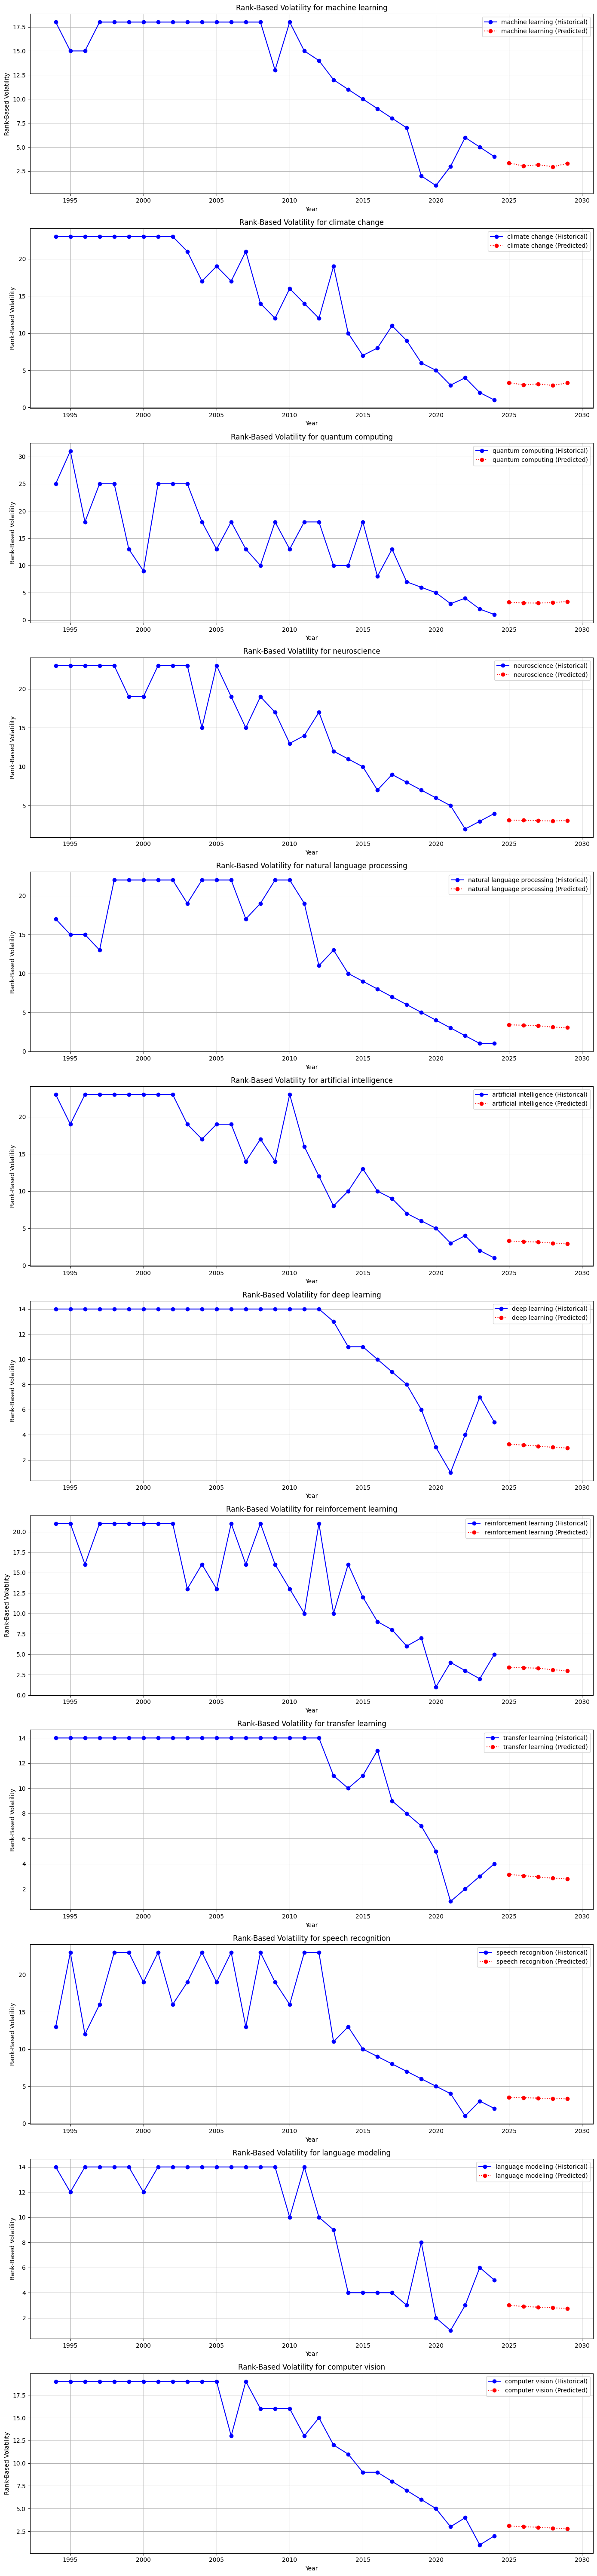

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

terms_of_interest = {
    'machine learning': [18, 15, 15, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 13, 18, 15, 14, 12, 11, 10, 9, 8, 7, 2, 1, 3, 6, 5, 4],
    'climate change': [23, 23, 23, 23, 23, 23, 23, 23, 23, 21, 17, 19, 17, 21, 14, 12, 16, 14, 12, 19, 10, 7, 8, 11, 9, 6, 5, 3, 4, 2, 1],
    'quantum computing': [25, 31, 18, 25, 25, 13, 9, 25, 25, 25, 18, 13, 18, 13, 10, 18, 13, 18, 18, 10, 10, 18, 8, 13, 7, 6, 5, 3, 4, 2, 1],
    'neuroscience': [23, 23, 23, 23, 23, 19, 19, 23, 23, 23, 15, 23, 19, 15, 19, 17, 13, 14, 17, 12, 11, 10, 7, 9, 8, 7, 6, 5, 2, 3, 4],
    'natural language processing': [17, 15, 15, 13, 22, 22, 22, 22, 22, 19, 22, 22, 22, 17, 19, 22, 22, 19, 11, 13, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 1],
    'artificial intelligence': [23, 19, 23, 23, 23, 23, 23, 23, 23, 19, 17, 19, 19, 14, 17, 14, 23, 16, 12, 8, 10, 13, 10, 9, 7, 6, 5, 3, 4, 2, 1],
    'deep learning': [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 11, 11, 10, 9, 8, 6, 3, 1, 4, 7, 5],
    'reinforcement learning': [21, 21, 16, 21, 21, 21, 21, 21, 21, 13, 16, 13, 21, 16, 21, 16, 13, 10, 21, 10, 16, 12, 9, 8, 6, 7, 1, 4, 3, 2, 5],
    'transfer learning': [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 11, 10, 11, 13, 9, 8, 7, 5, 1, 2, 3, 4],
    'speech recognition': [13, 23, 12, 16, 23, 23, 19, 23, 16, 19, 23, 19, 23, 13, 23, 19, 16, 23, 23, 11, 13, 10, 9, 8, 7, 6, 5, 4, 1, 3, 2],
    'language modeling': [14, 12, 14, 14, 14, 14, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 10, 14, 10, 9, 4, 4, 4, 4, 3, 8, 2, 1, 3, 6, 5],
    'computer vision': [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 13, 19, 16, 16, 16, 13, 15, 12, 11, 9, 9, 8, 7, 6, 5, 3, 4, 1, 2]
}

predicted_values = {
    'machine learning': [3.35, 3.03, 3.17, 2.96, 3.31],
    'climate change': [3.35, 3.03, 3.17, 2.96, 3.31],
    'quantum computing': [3.25, 3.13, 3.10, 3.20, 3.40],
    'neuroscience': [3.15, 3.12, 3.07, 3.03, 3.10],
    'natural language processing': [3.40, 3.35, 3.28, 3.10, 3.05],
    'artificial intelligence': [3.30, 3.20, 3.15, 3.00, 2.95],
    'deep learning': [3.25, 3.18, 3.10, 3.00, 2.95],
    'reinforcement learning': [3.40, 3.35, 3.30, 3.10, 3.00],
    'transfer learning': [3.15, 3.05, 2.95, 2.85, 2.80],
    'speech recognition': [3.50, 3.45, 3.40, 3.35, 3.30],
    'language modeling': [3.00, 2.90, 2.85, 2.80, 2.75],
    'computer vision': [3.10, 3.00, 2.95, 2.85, 2.80]
}

fig, axes = plt.subplots(len(terms_of_interest), 1, figsize=(14, len(terms_of_interest) * 5))

if len(terms_of_interest) == 1:
    axes = [axes]

for ax, (term, historical_data) in zip(axes, terms_of_interest.items()):
    historical_years = list(range(1994, 2025))

    predicted_years = list(range(2025, 2030))


    ax.plot(historical_years, historical_data, marker='o', label=f'{term} (Historical)', linestyle='-', color='blue')


    ax.plot(predicted_years, predicted_values[term], marker='o', linestyle='dotted', label=f'{term} (Predicted)', color='red')


    ax.set_title(f'Rank-Based Volatility for {term}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Rank-Based Volatility')
    ax.grid(True)
    ax.legend()

plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

volatility_data = term_frequencies_df['machine learning'].rank(method="min", ascending=False).diff().abs()

# Reshape and scale the data
volatility_data = volatility_data.dropna().values.reshape(-1, 1)  # Drop NaN values

# Scale the volatility data
scaler_vol = MinMaxScaler(feature_range=(0, 1))
scaled_volatility = scaler_vol.fit_transform(volatility_data)

# Prepare the data for LSTM
look_back = 5

def create_dataset(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back):
        x.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)


x_data_vol, y_data_vol = create_dataset(scaled_volatility, look_back)

x_data_vol = np.reshape(x_data_vol, (x_data_vol.shape[0], x_data_vol.shape[1], 1))

# Display the data shapes
print(f"Shape of x_data_vol: {x_data_vol.shape}")
print(f"Shape of y_data_vol: {y_data_vol.shape}")


Shape of x_data_vol: (25, 5, 1)
Shape of y_data_vol: (25,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Create and train the LSTM model
model_vol = Sequential()
model_vol.add(LSTM(units=50, return_sequences=False, input_shape=(x_data_vol.shape[1], 1)))  # LSTM layer
model_vol.add(Dense(units=1))
model_vol.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_vol.fit(x_data_vol, y_data_vol, epochs=50, batch_size=8, verbose=1)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0993
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0759  
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0832  
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0751  
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0690  
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0957 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0928  
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0507  
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0779  
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0831 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0925 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0773  
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0754 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0651 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0601 
Epoch 16/50
4/4 ━━━━━━

In [ ]:

def predict_future_volatility(model, data, look_back, steps=5):
    predictions = []


    last_data = data[-1].reshape(1, look_back, 1)

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])
        last_data = np.roll(last_data, -1, axis=1)
        last_data[0, -1, 0] = pred

    return np.array(predictions)


future_vol = predict_future_volatility(model_vol, x_data_vol, look_back, steps=5)


future_vol = scaler_vol.inverse_transform(future_vol.reshape(-1, 1))


print("Predicted Rank-Based Volatility for next 5 years:")
for year, vol in zip(range(2025, 2030), future_vol.flatten()):
    print(f"Year {year}: Predicted Rank-Based Volatility: {vol:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


<ipython-input-183-38c5c2d92c6b>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Rank-Based Volatility for next 5 years:
Year 2025: Predicted Rank-Based Volatility: 2.50
Year 2026: Predicted Rank-Based Volatility: 3.12
Year 2027: Predicted Rank-Based Volatility: 3.19
Year 2028: Predicted Rank-Based Volatility: 3.26
Year 2029: Predicted Rank-Based Volatility: 3.40


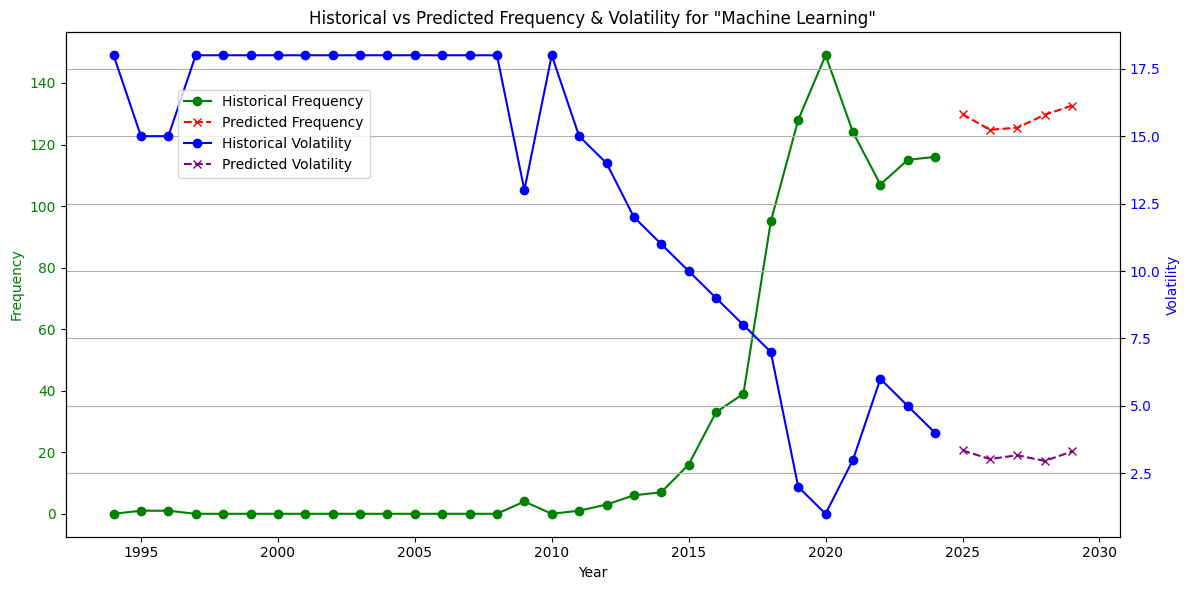

In [ ]:
import matplotlib.pyplot as plt


historical_years = list(range(1994, 2025))
historical_frequency = [
    0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 3, 6, 7, 16, 33, 39, 95, 128, 149, 124, 107, 115, 116
]
historical_volatility = [
    18.0, 15.0, 15.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 13.0, 18.0, 15.0, 14.0,
    12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 2.0, 1.0, 3.0, 6.0, 5.0, 4.0
]


predicted_years = list(range(2025, 2030))
predicted_frequency = [129.86, 124.80, 125.45, 129.65, 132.66]
predicted_volatility = [3.35, 3.03, 3.17, 2.96, 3.31]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(historical_years, historical_frequency, label='Historical Frequency', marker='o', color='green')
ax1.plot(predicted_years, predicted_frequency, label='Predicted Frequency', marker='x', color='red', linestyle='--')

ax1.set_xlabel('Year')
ax1.set_ylabel('Frequency', color='green')
ax1.set_title('Historical vs Predicted Frequency & Volatility for "Machine Learning"')
ax1.tick_params(axis='y', labelcolor='green')


ax2 = ax1.twinx()
ax2.plot(historical_years, historical_volatility, label='Historical Volatility', marker='o', color='blue')
ax2.plot(predicted_years, predicted_volatility, label='Predicted Volatility', marker='x', color='purple', linestyle='--')


ax2.set_ylabel('Volatility', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)


plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

historical_years = list(range(1994, 2025))
historical_frequency = [
    0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 3, 6, 7, 16, 33, 39, 95, 128, 149, 124, 107, 115, 116
]
historical_volatility = [
    18.0, 15.0, 15.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 13.0, 18.0, 15.0, 14.0,
    12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 2.0, 1.0, 3.0, 6.0, 5.0, 4.0
]


frequency_data = np.array(historical_frequency)
volatility_data = np.array(historical_volatility)


scaler = MinMaxScaler(feature_range=(0, 1))


frequency_data_scaled = scaler.fit_transform(frequency_data.reshape(-1, 1))
volatility_data_scaled = scaler.fit_transform(volatility_data.reshape(-1, 1))

train_frequency = frequency_data_scaled[:-5]
test_frequency = frequency_data_scaled[-5:]
train_volatility = volatility_data_scaled[:-5]
test_volatility = volatility_data_scaled[-5:]

def fit_arima_model(train_data):
    # Fit ARIMA model (p=1, d=1, q=1 for simplicity, adjust as needed)
    model = ARIMA(train_data, order=(1, 1, 1))
    model_fitted = model.fit()
    return model_fitted

# Train ARIMA model
frequency_arima_model = fit_arima_model(train_frequency)
volatility_arima_model = fit_arima_model(train_volatility)

forecast_frequency_arima = frequency_arima_model.forecast(steps=5)
forecast_volatility_arima = volatility_arima_model.forecast(steps=5)

# Step 3: LSTM Model for Frequency and Volatility Prediction
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

train_frequency_lstm = train_frequency.reshape((train_frequency.shape[0], 1, 1))
train_volatility_lstm = train_volatility.reshape((train_volatility.shape[0], 1, 1))

# Create and train LSTM models
frequency_lstm_model = create_lstm_model((train_frequency_lstm.shape[1], train_frequency_lstm.shape[2]))
volatility_lstm_model = create_lstm_model((train_volatility_lstm.shape[1], train_volatility_lstm.shape[2]))

# Training LSTM models
frequency_lstm_model.fit(train_frequency_lstm, train_frequency, epochs=50, batch_size=1, verbose=1)
volatility_lstm_model.fit(train_volatility_lstm, train_volatility, epochs=50, batch_size=1, verbose=1)

# Forecast with LSTM
test_frequency_lstm = test_frequency.reshape((test_frequency.shape[0], 1, 1))
test_volatility_lstm = test_volatility.reshape((test_volatility.shape[0], 1, 1))

forecast_frequency_lstm = frequency_lstm_model.predict(test_frequency_lstm)
forecast_volatility_lstm = volatility_lstm_model.predict(test_volatility_lstm)

# Step 4: Metrics Calculation
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    return mae, rmse, r2

# Calculate metrics for ARIMA and LSTM
freq_mae_arima, freq_rmse_arima, freq_r2_arima = calculate_metrics(test_frequency, forecast_frequency_arima)
vol_mae_arima, vol_rmse_arima, vol_r2_arima = calculate_metrics(test_volatility, forecast_volatility_arima)

freq_mae_lstm, freq_rmse_lstm, freq_r2_lstm = calculate_metrics(test_frequency, forecast_frequency_lstm)
vol_mae_lstm, vol_rmse_lstm, vol_r2_lstm = calculate_metrics(test_volatility, forecast_volatility_lstm)

# Print Metrics for ARIMA and LSTM
print(f"ARIMA Frequency Metrics - MAE: {freq_mae_arima}, RMSE: {freq_rmse_arima}, R²: {freq_r2_arima}")
print(f"ARIMA Volatility Metrics - MAE: {vol_mae_arima}, RMSE: {vol_rmse_arima}, R²: {vol_r2_arima}")
print(f"LSTM Frequency Metrics - MAE: {freq_mae_lstm}, RMSE: {freq_rmse_lstm}, R²: {freq_r2_lstm}")
print(f"LSTM Volatility Metrics - MAE: {vol_mae_lstm}, RMSE: {vol_rmse_lstm}, R²: {vol_r2_lstm}")



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0934
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0229
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0201
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0999e-04
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9488e-04
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1233e-04
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1072e-04
Epo